# Collaboration and Competition

My submission for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

This is the central file you want to use. It contains
-    all the import statements and instructions to start the environment
-    calls to train
-    calls to test

Description and justification of the model architectures and hyperparameters, plot of rewards and ideas for future works can be found in my [report](../report.ipynb).

For more information, I encourage you to have a look at my [description of the project](../README.md) as well.

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

---

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import time
import os
import pickle
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents = 2
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action = 2
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space -- Each observes a state with length: 24
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


The **observation space** consists of **8 variables** corresponding to
- the `position [x, y]`
- and `velocity [vx, vy]`
- of the `ball`
- and `racket`.

Each agent receives its own, local observation. **Two continuous actions** are available, corresponding to

- `movement toward (or away from) the net`
- and `jumping`. 

For each agent, the **"state"** issued by the environment is actually the **concatenation of 3 successive observations**. The most recent being at the end.

- Hence, for each agent `len(state) = 24`

Let's define a function to print the actions and states for the two agents.

In [5]:
# !pip install tabulate
# print transitions s-a-s'-a'-s'' for one single agent
from tabulate import tabulate
def print_state(single_state, actions_deque, agent_name):
    full_actions = []
    for i in range(3):
        full_actions = full_actions + [""]*2  # padding
        full_actions.append("{:.3f}".format(actions_deque[i][0]))
        full_actions.append("{:.3f}".format(actions_deque[i][1]))
        full_actions = full_actions + [""]*4  # padding
    state_vector_names = ['racket pos x', 'racket pos y', 'racket vel x', 'racket vel y',
                          'ball pos x', 'ball pos y', 'ball vel x', 'ball vel y']
    res = []
    for i, e in enumerate(state_vector_names):
        line = []
        for k in range(3):
            line.append(full_actions[i+k*8])
            line.append(single_state[i+k*8])        
        line[0] = e
        res.append(line)
    headers = [agent_name, "s_t-2", "a_t-2", "s_t-1", "a_t-1", "s_t"]
    print(tabulate(res, headers=headers, numalign="right", floatfmt=".3f"))

# print and compare states for both agents
def print_both_states(full_state):
    state_vector_names = ['racket pos x', 'racket pos y', 'racket vel x', 'racket vel y',
                          'ball pos x', 'ball pos y', 'ball vel x', 'ball vel y']
    res = []
    for i, e in enumerate(state_vector_names):
        line = [[full_state[0][i+k*8], full_state[1][i+k*8]] for k in range(3)]
        line = [e for l in line for e in l]
        line.insert(0, e)
        res.append(line)
    headers = ["", "st-2_A1", "st-2_A2", "st-1_A1", "st-1_A2", "st_A1", "st_A2"]
    print(tabulate(res, headers=headers, numalign="right", floatfmt=".3f"))

In [6]:
print('The initial states for the both agents look like:')
print_state(states[0], [[-1, -1], [0, 0], [1, 1]], "Agent_0")

The initial states for the both agents look like:
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -6.653
racket pos y    0.000             0.000           -1.500
racket vel x    0.000  0.000      0.000  1.000    -0.000
racket vel y    0.000  0.000      0.000  1.000     0.000
ball pos x      0.000             0.000            6.832
ball pos y      0.000             0.000            6.000
ball vel x      0.000             0.000           -0.000
ball vel y      0.000             0.000            0.000


In [7]:
# env.close()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [8]:
random_actions = False

In [9]:
# run steps in the environment. Either random or controlled by an agent
def show(n_runs, random_flag):
    actions_deque = deque(maxlen=3)  # collect 3 latest actions
    actions_deque.append([[0, 0], [0, 0]])
    actions_deque.append([[0, 0], [0, 0]])
    actions_deque.append([[0, 0], [0, 0]])
    for i in range(1, n_runs):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        print_both_states(states)
        print_state(states[0], [a[0] for a in actions_deque], "Agent_0")
        print_state(states[1], [a[1] for a in actions_deque], "Agent_1")
        while True:
            if random_flag:
                actions = np.random.randn(num_agents, action_size)
                actions = np.clip(actions, -1, 1)
            else:
                actions = agent.act(states)
            actions_deque.append(actions)

            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            print_both_states(states)
            print_state(states[0], [a[0] for a in actions_deque], "Agent_0")
            print_state(states[1], [a[1] for a in actions_deque], "Agent_1")
            if np.any(dones):                                  # exit loop if episode finished
                print('\nDONE')
                break
        print('Score (max over agents) from episode {}: {}\n'.format(i, np.max(scores)))

In [10]:
if random_actions:
    show(n_runs=6, random_flag=True)

When finished, you can close the environment.

In [11]:
if random_actions:
    env.close()

### 4. Training

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [17]:
model_dir= os.getcwd()+"/checkpoints_4"
os.makedirs(model_dir, exist_ok=True)

In [18]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
scores_global = []

In [19]:
def ddpg(name, n_max_episodes=3000):
    noise = 1.0
    mini_noise = 0.02
    noise_reduction = 0.9977

    scores_global = []                                    # collect scores for each episode
    scores_deque = deque(maxlen=100)                      # collect 100 latest scores
    start_learning = time.time()
    scores_window = deque(maxlen=100)  # last 100 scores
    scrs = []

    for i_episode in range(1, n_max_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment    
        states = env_info.vector_observations             # get the current state (for each agent)
        scores = np.zeros(num_agents)                     # initialize the score (for each agent)
        agent.reset_random()                                     # reset noise process
#         noise *= noise_reduction

        start_episode = time.time()
        for _ in count():
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]      # send all actions to the environment
            next_states = env_info.vector_observations    # get next state (for each agent)
            rewards = env_info.rewards                    # get reward (for each agent)
            dones = env_info.local_done                   # see if episode finished
            scores += rewards                             # update the score (for each agent)
            
#             print(states.shape, actions.shape, rewards, next_states.shape, dones)

#             for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
#                 print(state.shape, action.shape, reward, next_state.shape, done)
#                 agent.step(state, action, reward, next_state, done)
                
            agent.step(states, actions, rewards, next_states, dones)
            
            if np.any(dones):                             # exit loop if episode finished
                break
            
            states = next_states                          # roll over states to next time step

#         if sum(n > 0 for n in scores):
#             print(scores)

        score = np.max(scores)                           # average over 20 agents for this episode
        scores_window.append(score)
        scores_global.append(score)
#         scrs.append(score)
        
#         if i_episode % 10 == 0:
#             print('epi={} noise={:.2f} score[ep]={:.2f} mean[100]={:.2f} max[100]={:.2f} min[100]={:.2f} std[100]={:.2f} dur[ep]={:.2f}'\
#                   .format(i_episode, noise, score, np.mean(scores_deque), np.max(scores_deque), np.min(scores_deque), np.std(scores_deque), time.time()-start_episode), end="\n")
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if i_episode % 50 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoints_4/actor_-'+str(name)+"_"+str(i_episode)+'.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoints_4/critic_-'+str(name)+"_"+str(i_episode)+'.pth')
        
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.critic_local.state_dict(), 'trained-weights_2/checkpoint_critic.pth')
            torch.save(agent.actor_local.state_dict(), 'trained-weights_2/checkpoint_actor.pth')
            break
            
    return scores_global

Episode 10	Average Score: 0.00
Episode 20	Average Score: 0.00
Episode 30	Average Score: 0.00
Episode 40	Average Score: 0.01
Episode 50	Average Score: 0.01
Episode 60	Average Score: 0.01
Episode 70	Average Score: 0.00
Episode 80	Average Score: 0.00
Episode 90	Average Score: 0.00
Episode 100	Average Score: 0.00
Episode 110	Average Score: 0.00
Episode 120	Average Score: 0.00
Episode 130	Average Score: 0.00
Episode 140	Average Score: 0.01
Episode 150	Average Score: 0.01
Episode 160	Average Score: 0.01
Episode 170	Average Score: 0.02
Episode 180	Average Score: 0.02
Episode 190	Average Score: 0.03
Episode 200	Average Score: 0.04
Episode 210	Average Score: 0.04
Episode 220	Average Score: 0.05
Episode 230	Average Score: 0.05
Episode 240	Average Score: 0.05
Episode 250	Average Score: 0.06
Episode 260	Average Score: 0.06
Episode 270	Average Score: 0.06
Episode 280	Average Score: 0.06
Episode 290	Average Score: 0.06
Episode 300	Average Score: 0.05
Episode 310	Average Score: 0.06
Episode 320	Avera

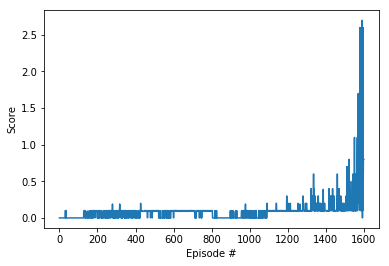

In [21]:
seed = 80

agent = Agent(state_size=state_size, action_size=action_size, seed=seed)
scores = ddpg(name=seed)

print(scores)
# save scores
logfile_name = str(seed)+".txt"
with open(logfile_name, "wb") as fp:
    pickle.dump(scores, fp)
    
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000149011612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

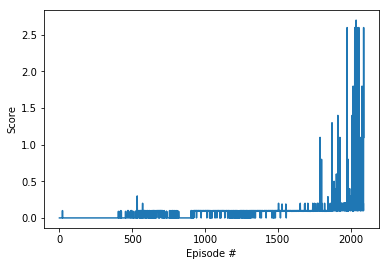

In [16]:
seed = 80

# agent = Agent(state_size=state_size, action_size=action_size, seed=seed)
# scores = ddpg(name=seed)

print(scores)
# save scores
logfile_name = str(seed)+".txt"
with open(logfile_name, "wb") as fp:
    pickle.dump(scores, fp)
    
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [17]:
# each choice of hyperparameters is executed under five random seeds
seeds = [random.randint(1, 100) for _ in range(1)]
print(seeds)
for i in seeds:
    print("--- seed = {} ---".format(i))
    agent = Agent(state_size=state_size, action_size=action_size, seed=i)
    scores = ddpg(name=i)

    print(scores)
    # save scores
    logfile_name = str(i)+".txt"
    with open(logfile_name, "wb") as fp:
        pickle.dump(scores, fp)
    
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

[80]
--- seed = 80 ---
Episode 10	Average Score: 0.01
Episode 20	Average Score: 0.01
Episode 30	Average Score: 0.00
Episode 40	Average Score: 0.00
Episode 50	Average Score: 0.00
Episode 60	Average Score: 0.00
Episode 70	Average Score: 0.00
Episode 80	Average Score: 0.00
Episode 90	Average Score: 0.00
Episode 100	Average Score: 0.00
Episode 110	Average Score: 0.00
Episode 120	Average Score: 0.00
Episode 130	Average Score: 0.00
Episode 140	Average Score: 0.00
Episode 150	Average Score: 0.00
Episode 160	Average Score: 0.00
Episode 170	Average Score: 0.00
Episode 180	Average Score: 0.00
Episode 190	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 210	Average Score: 0.00
Episode 220	Average Score: 0.00
Episode 230	Average Score: 0.00
Episode 240	Average Score: 0.00
Episode 250	Average Score: 0.00
Episode 260	Average Score: 0.00
Episode 270	Average Score: 0.00
Episode 280	Average Score: 0.00
Episode 290	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 310	Average Score:

Episode 2510	Average Score: 0.10
Episode 2520	Average Score: 0.10
Episode 2530	Average Score: 0.10
Episode 2540	Average Score: 0.10
Episode 2550	Average Score: 0.10
Episode 2560	Average Score: 0.11
Episode 2570	Average Score: 0.11
Episode 2580	Average Score: 0.12
Episode 2590	Average Score: 0.14
Episode 2600	Average Score: 0.15
Episode 2610	Average Score: 0.18
Episode 2620	Average Score: 0.21
Episode 2630	Average Score: 0.24
Episode 2640	Average Score: 0.30
Episode 2650	Average Score: 0.30
Episode 2660	Average Score: 0.33
Episode 2670	Average Score: 0.36
Episode 2680	Average Score: 0.40
Episode 2690	Average Score: 0.48
Episode 2691	Average Score: 0.51
Environment solved in 2591 episodes!	Average Score: 0.51


FileNotFoundError: [Errno 2] No such file or directory: 'trained weights/checkpoint_critic.pth'

NameError: name 'scores' is not defined

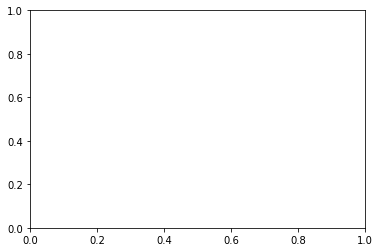

In [18]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Testing

In [12]:
# Load the saved model weights of a successful agent
agent = Agent(state_size=state_size, action_size=action_size, seed=67)
agent.actor_local.load_state_dict(torch.load('checkpoints_4/actor_-80_1600.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoints_4/critic_-80_1600.pth'))

In [13]:
show(n_runs=12, random_flag=False)

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000      0.000      0.000   -7.390   -6.700
racket pos y      0.000      0.000      0.000      0.000   -1.500   -1.500
racket vel x      0.000      0.000      0.000      0.000   -0.000    0.000
racket vel y      0.000      0.000      0.000      0.000    0.000    0.000
ball pos x        0.000      0.000      0.000      0.000    6.832   -6.832
ball pos y        0.000      0.000      0.000      0.000    5.996    5.996
ball vel x        0.000      0.000      0.000      0.000   -0.000    0.000
ball vel y        0.000      0.000      0.000      0.000    0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -7.390
racket pos y    0.000             0.000           -1.500
racket vel x    0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.245     -6.423     -6.036     -3.423   -8.799   -0.423
racket pos y     -1.858     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x    -22.452    -27.249    -27.908     30.000  -27.633   30.000
racket vel y      0.000      0.000      0.000      0.000    0.000    0.000
ball pos x        2.261     -2.261      1.361     -1.361    0.461   -0.461
ball pos y        4.142      4.142      4.532      4.532    4.824    4.824
ball vel x      -22.452    -27.249    -27.908     30.000  -27.633   30.000
ball vel y        0.000      0.000      0.000      0.000    0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.245            -6.036            -8.799
racket pos y   -1.858            -1.852            -1.852
racket vel x  -22.

Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900            -7.900           -10.781
racket pos y   -0.601            -0.117             0.269
racket vel x   -0.000  1.000     30.000  -0.961   -28.817
racket vel y    5.430  -1.000     4.449  -1.000     3.468
ball pos x     -3.139            -4.039            -4.939
ball pos y      5.010             4.811             4.515
ball vel x     -0.000            30.000           -28.817
ball vel y      5.430             4.449             3.468
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.735            -4.058           -1.058
racket pos y   -0.601            -0.117            0.269
racket vel x  -27.942  0.892     26.767  1.000    30.000
racket vel y    5.430  -1.000     4.449  -1.000    3.468
ball pos x      3.139             4.039            4.939
ball pos y      5.010

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -9.651    -10.900    -10.919  -10.900  -10.900
racket pos y      0.839      0.839      0.832      0.832    0.728    0.728
racket vel x     -0.000    -28.663     -0.000      0.000   -0.000    0.000
racket vel y      0.525      0.525     -0.456     -0.456   -1.437   -1.437
ball pos x       -7.639      7.639     -8.539      8.539   -9.439    9.439
ball pos y        3.036      3.036      2.346      2.346    1.559    1.559
ball vel x       -0.000    -28.663     -0.000      0.000   -0.000    0.000
ball vel y        0.525      0.525     -0.456     -0.456   -1.437   -1.437
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y    0.839             0.832             0.728
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.993     -4.900    -10.975     -1.900   -7.981   -0.401
racket pos y     -2.055     -0.174     -1.352     -0.671   -0.750   -1.266
racket vel x    -29.921     30.000    -29.818     30.000   29.943   29.943
racket vel y    -11.613     -4.380      6.608     -5.361    5.627   -6.342
ball pos x       -7.278      7.278     -6.378      6.378   -5.478    5.478
ball pos y        3.665      3.665      4.271      4.271    4.778    4.778
ball vel x      -29.921     30.000    -29.818     30.000   29.943   29.943
ball vel y      -11.613     -4.380      6.608     -5.361    5.627   -6.342
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.993           -10.975           -7.981
racket pos y   -2.055            -1.352           -0.750
racket vel x  -29.921 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.753    -10.900    -10.588    -10.900   -7.588  -10.900
racket pos y      0.676     -1.852      0.788     -1.852    0.801   -1.184
racket vel x    -27.949      0.000    -28.341      0.000   30.000   -0.000
racket vel y      1.703      0.000      0.722      0.000   -0.259    6.411
ball pos x       -1.878      1.878     -0.978      0.978   -0.078    0.078
ball pos y        5.828      5.828      5.845      5.845    5.764    5.764
ball vel x      -27.949      0.000    -28.341      0.000   30.000   -0.000
ball vel y        1.703      0.000      0.722      0.000   -0.259    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.753           -10.588           -7.588
racket pos y    0.676             0.788            0.801
racket vel x  -27.949 

ball vel y      3.468             2.487             1.506
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.903    -10.900     -7.903    -10.900   -4.903  -10.900
racket pos y     -0.127      0.557     -0.604      0.747   -1.179    0.839
racket vel x     -0.000      0.000     30.000      0.000   30.000   -0.000
racket vel y     -4.183      2.487     -5.164      1.506   -6.145    0.525
ball pos x        3.522     -3.522      4.422     -4.422    5.322   -5.322
ball pos y        4.459      4.459      3.887      3.887    3.218    3.218
ball vel x       -0.000      0.000     30.000      0.000   30.000   -0.000
ball vel y       -4.183      2.487     -5.164      1.506   -6.145    0.525
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.903            -7.903           -4.903
racket pos y   -0.127

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.494     -2.130     -1.494     -0.400   -4.389   -3.895
racket pos y      0.208     -0.944      0.516     -1.850    0.725   -1.852
racket vel x     30.000     30.000     30.000     30.000  -28.955  -28.955
racket vel y      3.665    -10.705      2.684     -0.493    1.703   -0.000
ball pos x        5.856     -5.856      4.956     -4.956    4.056   -4.056
ball pos y        2.962      2.962      3.666      3.666    4.271    4.271
ball vel x       30.000     30.000     30.000     30.000  -28.955  -28.955
ball vel y        3.665    -10.705      2.684     -0.493    1.703   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -4.494            -1.494            -4.389
racket pos y    0.208             0.516             0.725
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.219     -0.772    -10.991     -3.669  -10.900   -0.669
racket pos y      0.582     -1.852      0.301     -1.852   -0.078   -1.852
racket vel x    -26.884     30.000     -0.000    -26.689   -0.000   30.000
racket vel y     -2.221     -0.000     -3.202     -0.000   -4.183   -0.000
ball pos x        0.456     -0.456     -0.444      0.444   -1.344    1.344
ball pos y        5.713      5.713      5.828      5.828    5.846    5.846
ball vel x      -26.884     30.000     -0.000    -26.689   -0.000   30.000
ball vel y       -2.221     -0.000     -3.202     -0.000   -4.183   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -9.219           -10.991           -10.900
racket pos y    0.582             0.301            -0.078
racket vel x  -26.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -2.202    -10.900     -4.933   -7.900   -1.933
racket pos y     -1.255     -1.184     -0.653     -0.601   -0.149   -0.117
racket vel x     -0.000    -12.023     -0.000    -27.310   30.000   30.000
racket vel y      6.608      6.411      5.627      5.430    4.646    4.449
ball pos x       -4.044      4.044     -4.944      4.944   -5.844    5.844
ball pos y        5.308      5.308      4.933      4.933    4.460    4.460
ball vel x       -0.000    -12.023     -0.000    -27.310   30.000   30.000
ball vel y        6.608      6.411      5.627      5.430    4.646    4.449
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.900           -7.900
racket pos y   -1.255            -0.653           -0.149
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -3.043    -10.900     -0.400   -8.009   -0.400
racket pos y      0.774      0.747      0.885      0.839    0.433    0.832
racket vel x     -0.000      6.862     -0.000     30.000   30.000   30.000
racket vel y      1.703      1.506      0.722      0.525   -8.023   -0.456
ball pos x       -8.544      8.544     -9.444      9.444   -9.044    9.044
ball pos y        2.451      2.451      1.585      1.585    2.209    2.209
ball vel x       -0.000      6.862     -0.000     30.000   30.000   30.000
ball vel y        1.703      1.506      0.722      0.525   -8.023   -0.456
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.900           -8.009
racket pos y    0.774             0.885            0.433
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.920     -0.400     -6.920     -0.400   -3.920   -3.383
racket pos y     -0.043     -0.671      0.323     -1.266    0.592   -1.959
racket vel x    -25.448     30.000     30.000     30.000   30.000  -23.829
racket vel y      4.253     -5.361      3.272     -6.342    2.291   -7.323
ball pos x       -4.544      4.544     -3.644      3.644   -2.744    2.744
ball pos y        5.238      5.238      5.549      5.549    5.763    5.763
ball vel x      -25.448     30.000     30.000     30.000   30.000  -23.829
ball vel y        4.253     -5.361      3.272     -6.342    2.291   -7.323
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.920            -6.920           -3.920
racket pos y   -0.043             0.323            0.592
racket vel x  -25.448 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.064    -10.690     -3.064    -10.900   -5.575  -10.900
racket pos y      0.808     -1.852      0.684     -1.852    0.462   -1.184
racket vel x     27.006    -24.625     30.000      0.000  -25.107    0.000
racket vel y     -0.652      0.000     -1.633      0.000   -2.614    6.411
ball pos x       -0.044      0.044      0.856     -0.856    1.756   -1.756
ball pos y        5.814      5.814      5.635      5.635    5.358    5.358
ball vel x       27.006    -24.625     30.000      0.000  -25.107    0.000
ball vel y       -0.652      0.000     -1.633      0.000   -2.614    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -6.064            -3.064            -5.575
racket pos y    0.808             0.684             0.462
racket vel x   27.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.629    -10.448     -4.629    -10.900   -1.629  -10.900
racket pos y     -0.793      0.269     -1.408      0.557   -1.876    0.747
racket vel x     30.000    -25.480     30.000      0.000   30.000   -0.000
racket vel y     -5.557      3.468     -6.538      2.487    0.000    1.506
ball pos x        4.456     -4.456      5.356     -5.356    6.256   -6.256
ball pos y        3.937      3.937      3.268      3.268    2.500    2.500
ball vel x       30.000    -25.480     30.000      0.000   30.000   -0.000
ball vel y       -5.557      3.468     -6.538      2.487    0.000    1.506
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.629            -4.629           -1.629
racket pos y   -0.793            -1.408           -1.876
racket vel x   30.000 

ball vel y     -8.219            -9.200           -10.181
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.042     -2.153    -11.132     -0.400   -8.132   -3.243
racket pos y     -0.141     -0.670      0.245     -1.648    0.533   -1.852
racket vel x    -24.608     30.000    -20.899     30.000   30.000  -22.426
racket vel y      4.449     -9.200      3.468    -10.181    2.487    0.000
ball pos x        5.496     -5.496      4.596     -4.596    3.696   -3.696
ball pos y        3.393      3.393      4.078      4.078    4.664    4.664
ball vel x      -24.608     30.000    -20.899     30.000   30.000  -22.426
ball vel y        4.449     -9.200      3.468    -10.181    2.487    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.042           -11.132           -8.132
racket pos y   -0.141

ball vel y      0.000             0.000            0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -11.346     -4.962    -10.900     -1.962  -10.900   -4.454
racket pos y      0.809     -1.852      0.704     -1.852    0.502   -1.852
racket vel x    -24.006    -24.635     -0.000     30.000   -0.000  -24.920
racket vel y     -0.456      0.000     -1.437      0.000   -2.418    0.000
ball pos x        0.996     -0.996      0.096     -0.096   -0.804    0.804
ball pos y        5.833      5.833      6.027      6.027    6.123    6.123
ball vel x      -24.006    -24.635     -0.000     30.000   -0.000  -24.920
ball vel y       -0.456      0.000     -1.437      0.000   -2.418    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -11.346           -10.900           -10.900
racket pos y    0.8

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -9.093    -10.900     -6.093  -10.900   -3.093
racket pos y     -1.289     -0.601     -1.158     -0.117   -0.576    0.269
racket vel x     -0.000    -25.766     -0.000     30.000   -0.000   30.000
racket vel y     -6.342      5.430      6.411      4.449    5.430    3.468
ball pos x       -4.404      4.404     -5.304      5.304   -6.204    6.204
ball pos y        5.524      5.524      5.129      5.129    4.636    4.636
ball vel x       -0.000    -25.766     -0.000     30.000   -0.000   30.000
ball vel y       -6.342      5.430      6.411      4.449    5.430    3.468
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -1.289            -1.158            -0.576
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -0.400     -8.011     -0.400   -5.011   -0.400
racket pos y      0.772      0.832      0.388      0.728   -0.411    0.525
racket vel x     -0.000     30.000     30.000     30.000   30.000   30.000
racket vel y      1.506     -0.456     -7.404     -1.437   -8.385   -2.418
ball pos x       -9.804      9.804     -9.392      9.392   -8.492    8.492
ball pos y        1.684      1.684      2.326      2.326    3.128    3.128
ball vel x       -0.000     30.000     30.000     30.000   30.000   30.000
ball vel y        1.506     -0.456     -7.404     -1.437   -8.385   -2.418
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900            -8.011           -5.011
racket pos y    0.772             0.388           -0.411
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.298     -0.400     -9.992     -3.664   -6.992   -6.400
racket pos y     -0.689     -0.671     -0.185     -1.266    0.221   -1.959
racket vel x     30.000     30.000    -26.939    -26.636   30.000  -27.369
racket vel y      5.627     -5.361      4.646     -6.342    3.665   -7.323
ball pos x       -5.792      5.792     -4.892      4.892   -3.992    3.992
ball pos y        4.945      4.945      5.355      5.355    5.666    5.666
ball vel x       30.000     30.000    -26.939    -26.636   30.000  -27.369
ball vel y        5.627     -5.361      4.646     -6.342    3.665   -7.323
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.298            -9.992           -6.992
racket pos y   -0.689            -0.185            0.221
racket vel x   30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.341    -10.900     -6.341    -10.900   -3.341  -10.900
racket pos y      0.849     -1.852      0.863     -1.184    0.778   -0.601
racket vel x    -26.535      0.000     30.000     -0.000   30.000   -0.000
racket vel y      0.722      0.000     -0.259      6.411   -1.240    5.430
ball pos x       -1.292      1.292     -0.392      0.392    0.508   -0.508
ball pos y        6.012      6.012      5.931      5.931    5.752    5.752
ball vel x      -26.535      0.000     30.000     -0.000   30.000   -0.000
ball vel y        0.722      0.000     -0.259      6.411   -1.240    5.430
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.341            -6.341           -3.341
racket pos y    0.849             0.863            0.778
racket vel x  -26.535 

ball vel y     -3.202            -4.183           -5.164
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.519           -10.900           -10.900
racket pos y    0.269             0.557             0.747
racket vel x  -26.188  -0.881     0.000  -0.887     0.000
racket vel y    3.468  -1.000     2.487  -1.000     1.506
ball pos x     -2.308            -3.208            -4.108
ball pos y      5.099             4.626             4.054
ball vel x    -26.188             0.000             0.000
ball vel y      3.468             2.487             1.506
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -11.321    -10.900     -8.321    -10.900   -5.321  -10.900
racket pos y     -0.065      0.557     -0.542      0.747   -1.118    0.839
racket vel x    -26.421      0.000     30.000      0.000   30.0

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.595     -7.900     -6.182     -5.000   -3.182   -2.000
racket pos y     -0.540      0.525     -0.056     -0.493    0.330   -1.610
racket vel x    -25.946     30.000    -25.873     30.000   30.000   30.000
racket vel y      5.430     -2.418      4.449    -10.580    3.468  -11.561
ball pos x        7.708     -7.708      6.632     -6.632    5.732   -5.732
ball pos y        0.831      0.831      2.094      2.094    2.857    2.857
ball vel x      -25.946     30.000    -25.873     30.000   30.000   30.000
ball vel y        5.430     -2.418      4.449    -10.580    3.468  -11.561
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -3.595            -6.182           -3.182
racket pos y   -0.540            -0.056            0.330
racket vel x  -25.946 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.495     -5.595     -2.540     -2.595   -5.144   -0.400
racket pos y      0.900     -1.852      0.893     -1.852    0.789   -1.852
racket vel x     10.841    -20.155     -0.450     30.000  -26.037   30.000
racket vel y      0.525     -0.000     -0.456     -0.000   -1.437   -0.000
ball pos x        3.032     -3.032      2.132     -2.132    1.232   -1.232
ball pos y        4.556      4.556      4.927      4.927    5.199    5.199
ball vel x       10.841    -20.155     -0.450     30.000  -26.037   30.000
ball vel y        0.525     -0.000     -0.456     -0.000   -1.437   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -2.495            -2.540            -5.144
racket pos y    0.900             0.893             0.789
racket vel x   10.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -3.698    -10.900     -0.698  -10.900   -3.830
racket pos y     -0.113     -1.852     -0.610     -1.852   -1.205   -1.184
racket vel x     -0.000    -26.980     -0.000     30.000   -0.000  -28.302
racket vel y     -4.380     -0.000     -5.361     -0.000   -6.342    6.411
ball pos x       -1.468      1.468     -2.368      2.368   -3.268    3.268
ball pos y        5.427      5.427      5.306      5.306    5.088    5.088
ball vel x       -0.000    -26.980     -0.000     30.000   -0.000  -28.302
ball vel y       -4.380     -0.000     -5.361     -0.000   -6.342    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -0.113            -0.610            -1.205
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.900     -0.687    -10.706     -3.806  -10.900   -5.842
racket pos y     -0.235      0.269      0.171      0.557    0.479    0.747
racket vel x     30.000     30.000    -28.060    -28.060   -0.000  -20.361
racket vel y      4.646      3.468      3.665      2.487    2.684    1.506
ball pos x       -5.968      5.968     -6.868      6.868   -7.768    7.768
ball pos y        3.844      3.844      3.234      3.234    2.525    2.525
ball vel x       30.000     30.000    -28.060    -28.060   -0.000  -20.361
ball vel y        4.646      3.468      3.665      2.487    2.684    1.506
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.900           -10.706           -10.900
racket pos y   -0.235             0.171             0.479
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.011    -10.902     -7.723     -7.902  -10.409   -4.902
racket pos y     -0.297      0.728     -1.175      0.525   -1.157    0.225
racket vel x     30.000      0.000    -27.118     30.000  -26.861   30.000
racket vel y     -8.189     -1.437     -9.170     -2.418    6.411   -3.399
ball pos x       -7.716      7.716     -6.816      6.816   -5.916    5.916
ball pos y        2.846      2.846      3.570      3.570    4.195    4.195
ball vel x       30.000      0.000    -27.118     30.000  -26.861   30.000
ball vel y       -8.189     -1.437     -9.170     -2.418    6.411   -3.399
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -5.011            -7.723           -10.409
racket pos y   -0.297            -1.175            -1.157
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.012     -3.638     -4.012     -6.275   -6.770   -9.033
racket pos y      0.295     -1.266      0.583     -1.959    0.773   -1.852
racket vel x     30.000    -26.375     30.000    -26.371  -27.580  -27.580
racket vel y      3.468     -6.342      2.487     -7.323    1.506    0.000
ball pos x       -3.216      3.216     -2.316      2.316   -1.416    1.416
ball pos y        5.482      5.482      5.715      5.715    5.850    5.850
ball vel x       30.000    -26.375     30.000    -26.371  -27.580  -27.580
ball vel y        3.468     -6.342      2.487     -7.323    1.506    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.012            -4.012            -6.770
racket pos y    0.295             0.583             0.773
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.624    -10.900     -5.992    -10.900   -8.429   -7.900
racket pos y      0.754     -1.184      0.552     -0.601    0.251   -0.117
racket vel x     30.000     -0.000    -23.683     -0.000  -24.368   30.000
racket vel y     -1.437      6.411     -2.418      5.430   -3.399    4.449
ball pos x        1.284     -1.284      2.184     -2.184    3.084   -3.084
ball pos y        5.666      5.666      5.408      5.408    5.053    5.053
ball vel x       30.000     -0.000    -23.683     -0.000  -24.368   30.000
ball vel y       -1.437      6.411     -2.418      5.430   -3.399    4.449
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.624            -5.992            -8.429
racket pos y    0.754             0.552             0.251
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -1.859    -10.900     -0.400    -10.900   -3.276   -8.004
racket pos y     -1.932      0.839     -1.256      0.832   -0.654    0.579
racket vel x     30.000     -0.000     30.000     -0.000  -22.763   24.797
racket vel y     -7.323      0.525      6.608     -0.456    5.627   -8.867
ball pos x        6.684     -6.684      7.584     -7.584    7.929   -7.929
ball pos y        2.649      2.649      1.803      1.803    1.679    1.679
ball vel x       30.000     -0.000     30.000     -0.000  -22.763   24.797
ball vel y       -7.323      0.525      6.608     -0.456    5.627   -8.867
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -1.859            -0.400            -3.276
racket pos y   -1.932            -1.256            -0.654
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.474     -3.696     -2.562     -6.153   -4.848   -3.153
racket pos y      0.884     -1.852      0.897     -1.852    0.812   -1.852
racket vel x    -20.699     30.000     29.124    -24.562  -22.861   30.000
racket vel y      0.722      0.000     -0.259      0.000   -1.240    0.000
ball pos x        3.429     -3.429      2.529     -2.529    1.629   -1.629
ball pos y        4.903      4.903      5.254      5.254    5.506    5.506
ball vel x      -20.699     30.000     29.124    -24.562  -22.861   30.000
ball vel y        0.722      0.000     -0.259      0.000   -1.240    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -5.474            -2.562            -4.848
racket pos y    0.884             0.897             0.812
racket vel x  -20.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.914     -5.059    -10.900     -2.059  -10.900   -4.397
racket pos y     -0.031     -1.852     -0.508     -1.852   -1.083   -1.184
racket vel x     -0.000    -24.196     -0.000     30.000   -0.000  -23.377
racket vel y     -4.183      0.000     -5.164      0.000   -6.145    6.411
ball pos x       -1.071      1.071     -1.971      1.971   -2.871    2.871
ball pos y        5.675      5.675      5.536      5.536    5.298    5.298
ball vel x       -0.000    -24.196     -0.000     30.000   -0.000  -23.377
ball vel y       -4.183      0.000     -5.164      0.000   -6.145    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.914           -10.900           -10.900
racket pos y   -0.031            -0.508            -1.083
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.900     -0.641    -10.368     -3.468  -10.903   -5.773
racket pos y     -0.333      0.269      0.092      0.557    0.420    0.747
racket vel x     30.000     30.000    -24.680    -24.680   -0.000  -23.053
racket vel y      4.842      3.468      3.861      2.487    2.880    1.506
ball pos x       -5.571      5.571     -6.471      6.471   -7.371    7.371
ball pos y        3.995      3.995      3.365      3.365    2.636    2.636
ball vel x       30.000     30.000    -24.680    -24.680   -0.000  -23.053
ball vel y        4.842      3.468      3.861      2.487    2.880    1.506
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.900           -10.368           -10.903
racket pos y   -0.333             0.092             0.420
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.373     -4.900     -6.875     -1.900   -3.875   -0.400
racket pos y     -1.953      0.225     -1.277     -0.174   -0.675   -0.671
racket vel x    -23.600     30.000    -25.026     30.000   30.000   30.000
racket vel y     -9.955     -3.399      6.608     -4.380    5.627   -5.361
ball pos x       -5.879      5.879     -4.979      4.979   -4.079    4.079
ball pos y        3.975      3.975      4.522      4.522    4.970    4.970
ball vel x      -23.600     30.000    -25.026     30.000   30.000   30.000
ball vel y       -9.955     -3.399      6.608     -4.380    5.627   -5.361
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -4.373            -6.875           -3.875
racket pos y   -1.953            -1.277           -0.675
racket vel x  -23.600 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.520     -8.519     -6.039    -11.038   -8.216  -10.900
racket pos y      0.542     -1.852      0.752     -1.852    0.863   -1.852
racket vel x    -25.199    -25.199    -25.187    -25.187  -21.777    0.000
racket vel y      2.684      0.000      1.703      0.000    0.722    0.000
ball pos x       -1.379      1.379     -0.479      0.479    0.421   -0.421
ball pos y        5.728      5.728      5.784      5.784    5.743    5.743
ball vel x      -25.199    -25.199    -25.187    -25.187  -21.777    0.000
ball vel y        2.684      0.000      1.703      0.000    0.722    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.520            -6.039            -8.216
racket pos y    0.542             0.752             0.863
racket vel x  -25.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.900    -10.900     -7.900   -9.302  -10.570
racket pos y      0.609     -0.601      0.328     -0.117   -0.051    0.269
racket vel x     -0.000     -0.000     -0.000     30.000   15.974  -26.700
racket vel y     -2.221      5.430     -3.202      4.449   -4.183    3.468
ball pos x        3.121     -3.121      4.021     -4.021    4.921   -4.921
ball pos y        5.029      5.029      4.595      4.595    4.062    4.062
ball vel x       -0.000     -0.000     -0.000     30.000   15.974  -26.700
ball vel y       -2.221      5.430     -3.202      4.449   -4.183    3.468
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.900           -9.302
racket pos y    0.609             0.328           -0.051
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.400    -10.900     -3.534     -8.007   -6.046   -5.007
racket pos y     -1.499      0.839     -0.877      0.680   -0.354   -0.189
racket vel x     30.000     -0.000    -25.341     24.651  -25.124   30.000
racket vel y      6.804      0.525      5.823     -8.094    4.842   -9.075
ball pos x        7.621     -7.621      7.951     -7.951    7.051   -7.051
ball pos y        1.877      1.877      1.782      1.782    2.623    2.623
ball vel x       30.000     -0.000    -25.341     24.651  -25.124   30.000
ball vel y        6.804      0.525      5.823     -8.094    4.842   -9.075
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -0.400            -3.534            -6.046
racket pos y   -1.499            -0.877            -0.354
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -1.072     -7.167     -3.689     -4.167   -6.362   -6.840
racket pos y      0.628     -1.852      0.759     -1.852    0.792   -1.852
racket vel x     30.000    -26.203    -26.169     30.000  -26.728  -26.726
racket vel y      1.899      0.000      0.918      0.000   -0.063    0.000
ball pos x        4.351     -4.351      3.451     -3.451    2.551   -2.551
ball pos y        4.558      4.558      5.007      5.007    5.357    5.357
ball vel x       30.000    -26.203    -26.169     30.000  -26.728  -26.726
ball vel y        1.899      0.000      0.918      0.000   -0.063    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -1.072            -3.689            -6.362
racket pos y    0.628             0.759             0.792
racket vel x   30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -8.239     -3.500    -10.844     -6.105  -10.901   -3.105
racket pos y      0.302     -1.852     -0.058     -1.852   -0.515   -1.852
racket vel x    -26.350     30.000    -26.049    -26.049   -0.000   30.000
racket vel y     -3.006      0.000     -3.987      0.000   -4.968    0.000
ball pos x       -0.149      0.149     -1.049      1.049   -1.949    1.949
ball pos y        5.821      5.821      5.779      5.779    5.639    5.639
ball vel x      -26.350     30.000    -26.049    -26.049   -0.000   30.000
ball vel y       -3.006      0.000     -3.987      0.000   -4.968    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -8.239           -10.844           -10.901
racket pos y    0.302            -0.058            -0.515
racket vel x  -26.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -5.686     -7.900     -2.686  -10.731   -5.517
racket pos y     -0.828     -0.117     -0.305      0.269    0.120    0.557
racket vel x     -0.000     30.000     30.000     30.000  -28.310  -28.310
racket vel y      5.823      4.449      4.842      3.468    3.861    2.487
ball pos x       -4.649      4.649     -5.549      5.549   -6.449    6.449
ball pos y        4.631      4.631      4.098      4.098    3.468    3.468
ball vel x       -0.000     30.000     30.000     30.000  -28.310  -28.310
ball vel y        5.823      4.449      4.842      3.468    3.861    2.487
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900            -7.900           -10.731
racket pos y   -0.828            -0.305             0.120
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -8.011    -10.900     -5.124    -10.900   -6.423   -8.026
racket pos y      0.649      0.832     -0.111      0.728   -0.969    0.525
racket vel x     24.448      0.000     28.867     -0.000  -12.986   28.735
racket vel y     -7.012     -0.456     -7.993     -1.437   -8.974   -2.418
ball pos x       -8.557      8.557     -7.657      7.657   -6.757    6.757
ball pos y        1.849      1.849      2.690      2.690    3.433    3.433
ball vel x       24.448      0.000     28.867     -0.000  -12.986   28.735
ball vel y       -7.012     -0.456     -7.993     -1.437   -8.974   -2.418
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -8.011            -5.124            -6.423
racket pos y    0.649            -0.111            -0.969
racket vel x   24.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.577     -0.442     -6.795     -4.000   -3.996   -7.000
racket pos y     -0.157     -0.671      0.249     -1.266    0.556   -1.959
racket vel x    -30.000     27.890     27.820    -30.000   27.988  -30.000
racket vel y      4.646     -5.361      3.665     -6.342    2.684   -7.323
ball pos x       -4.057      4.057     -3.157      3.157   -2.257    2.257
ball pos y        5.074      5.074      5.424      5.424    5.677    5.677
ball vel x      -30.000     27.890     27.820    -30.000   27.988  -30.000
ball vel y        4.646     -5.361      3.665     -6.342    2.684   -7.323
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.577            -6.795           -3.996
racket pos y   -0.157             0.249            0.556
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.698    -10.900     -4.933    -10.900   -7.933  -10.900
racket pos y      0.890     -1.852      0.806     -1.184    0.623   -0.601
racket vel x     22.989      0.000     27.645     -0.000  -30.000   -0.000
racket vel y     -0.259      0.000     -1.240      6.411   -2.221    5.430
ball pos x        0.443     -0.443      1.343     -1.343    2.243   -2.243
ball pos y        5.846      5.846      5.706      5.706    5.468    5.468
ball vel x       22.989      0.000     27.645     -0.000  -30.000   -0.000
ball vel y       -0.259      0.000     -1.240      6.411   -2.221    5.430
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.698            -4.933            -7.933
racket pos y    0.890             0.806             0.623
racket vel x   22.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -8.339    -10.900     -5.822    -10.900   -3.372  -10.900
racket pos y     -0.515      0.557     -1.090      0.747   -1.763    0.839
racket vel x     25.605      0.000     25.170     -0.000   24.503   -0.000
racket vel y     -5.164      2.487     -6.145      1.506   -7.126    0.525
ball pos x        4.943     -4.943      5.843     -5.843    6.743   -6.743
ball pos y        4.166      4.166      3.535      3.535    2.807    2.807
ball vel x       25.605      0.000     25.170     -0.000   24.503   -0.000
ball vel y       -5.164      2.487     -6.145      1.506   -7.126    0.525
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -8.339            -5.822           -3.372
racket pos y   -0.515            -1.090           -1.763
racket vel x   25.605 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.000     -5.881     -4.405     -3.278   -1.847   -0.720
racket pos y     -0.079     -0.156      0.287     -1.139    0.556   -1.881
racket vel x    -30.000     26.148     25.951     26.030   25.579   25.574
racket vel y      4.253     -9.235      3.272    -10.216    2.291    0.000
ball pos x        7.494     -7.494      6.594     -6.594    5.694   -5.694
ball pos y        2.294      2.294      3.057      3.057    3.722    3.722
ball vel x      -30.000     26.148     25.951     26.030   25.579   25.574
ball vel y        4.253     -9.235      3.272    -10.216    2.291    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.000            -4.405           -1.847
racket pos y   -0.079             0.287            0.556
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.478     -4.388     -4.000     -1.790   -7.000   -4.790
racket pos y      0.772     -1.852      0.648     -1.852    0.426   -1.852
racket vel x     26.079    -30.000    -30.000     25.975  -30.000  -30.000
racket vel y     -0.652      0.000     -1.633      0.000   -2.614    0.000
ball pos x        2.994     -2.994      2.094     -2.094    1.194   -1.194
ball pos y        5.127      5.127      5.399      5.399    5.573    5.573
ball vel x       26.079    -30.000    -30.000     25.975  -30.000  -30.000
ball vel y       -0.652      0.000     -1.633      0.000   -2.614    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -0.478            -4.000            -7.000
racket pos y    0.772             0.648             0.426
racket vel x   26.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -2.750    -10.900     -5.750  -10.900   -8.750
racket pos y     -0.829     -1.852     -1.444     -1.184   -1.058   -0.601
racket vel x     -0.000     25.564     -0.000    -30.000   -0.000  -30.000
racket vel y     -5.557      0.000     -6.538      6.411    6.215    5.430
ball pos x       -1.506      1.506     -2.406      2.406   -3.306    3.306
ball pos y        5.507      5.507      5.288      5.288    4.972    4.972
ball vel x       -0.000     25.564     -0.000    -30.000   -0.000  -30.000
ball vel y       -5.557      0.000     -6.538      6.411    6.215    5.430
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -0.829            -1.444            -1.058
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -11.464     -6.803    -10.900     -9.803  -10.900  -10.901
racket pos y      0.336      0.557      0.604      0.747    0.775    0.839
racket vel x    -30.000    -30.000     -0.000    -30.000   -0.000    0.000
racket vel y      3.272      2.487      2.291      1.506    1.310    0.525
ball pos x       -6.006      6.006     -6.906      6.906   -7.806    7.806
ball pos y        3.434      3.434      2.725      2.725    1.918    1.918
ball vel x      -30.000    -30.000     -0.000    -30.000   -0.000    0.000
ball vel y        3.272      2.487      2.291      1.506    1.310    0.525
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -11.464           -10.900           -10.900
racket pos y    0.336             0.604             0.775
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.748     -8.506     -6.748     -6.055   -9.748   -3.665
racket pos y     -0.831      0.525     -1.748      0.225   -1.091   -0.174
racket vel x     23.936     23.938    -30.000     24.508  -30.000   23.905
racket vel y     -8.579     -2.418     -9.560     -3.399    6.215   -4.380
ball pos x       -6.387      6.387     -5.487      5.487   -4.587    4.587
ball pos y        3.344      3.344      3.989      3.989    4.536    4.536
ball vel x       23.936     23.938    -30.000     24.508  -30.000   23.905
ball vel y       -8.579     -2.418     -9.560     -3.399    6.215   -4.380
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.748            -6.748            -9.748
racket pos y   -0.831            -1.748            -1.091
racket vel x   23.

ball vel y      4.253             3.272             2.291
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.086            -6.086            -9.086
racket pos y   -1.266            -1.959            -1.852
racket vel x  -18.382  -1.000   -30.000  -1.000   -30.000
racket vel y   -6.342  -1.000    -7.323  -1.000     0.000
ball pos x      2.787             1.887             0.987
ball pos y      5.335             5.588             5.742
ball vel x    -18.382           -30.000           -30.000
ball vel y     -6.342            -7.323             0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.554     -6.086     -5.554     -9.086   -8.554  -10.899
racket pos y      0.303     -1.959      0.571     -1.852    0.741   -1.852
racket vel x     23.323    -30.000    -30.000    -30.000  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.900    -10.900    -10.900  -10.900   -8.461
racket pos y      0.787     -1.184      0.663     -0.601    0.441   -0.117
racket vel x     -0.000     -0.000     -0.000     -0.000   -0.000   24.383
racket vel y     -0.652      6.411     -1.633      5.430   -2.614    4.449
ball pos x        1.713     -1.713      2.613     -2.613    3.513   -3.513
ball pos y        5.617      5.617      5.379      5.379    5.043    5.043
ball vel x       -0.000     -0.000     -0.000     -0.000   -0.000   24.383
ball vel y       -0.652      6.411     -1.633      5.430   -2.614    4.449
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y    0.787             0.663             0.441
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.754    -10.900     -1.380    -10.900   -4.380   -8.592
racket pos y     -1.428      0.839     -1.042      0.832   -0.480    0.597
racket vel x     23.511     -0.000     23.739     -0.000  -30.000   19.412
racket vel y     -6.538      0.525      6.215     -0.456    5.234   -7.976
ball pos x        7.113     -7.113      8.013     -8.013    8.424   -8.424
ball pos y        2.718      2.718      1.891      1.891    1.679    1.679
ball vel x       23.511     -0.000     23.739     -0.000  -30.000   19.412
ball vel y       -6.538      0.525      6.215     -0.456    5.234   -7.976
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -3.754            -1.380            -4.380
racket pos y   -1.428            -1.042            -0.480
racket vel x   23.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.478    -10.902     -5.478     -8.415   -2.997  -11.415
racket pos y      0.620     -1.227      0.790     -0.644    0.862   -0.160
racket vel x     25.124      0.000    -30.000     24.871   24.814  -30.000
racket vel y      2.291      6.411      1.310      5.430    0.329    4.449
ball pos x        5.724     -5.724      4.824     -4.824    3.924   -3.924
ball pos y        3.908      3.908      4.455      4.455    4.903    4.903
ball vel x       25.124      0.000    -30.000     24.871   24.814  -30.000
ball vel y        2.291      6.411      1.310      5.430    0.329    4.449
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -2.478            -5.478           -2.997
racket pos y    0.620             0.790            0.862
racket vel x   25.124 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.000    -10.904    -10.000     -8.630  -10.902   -6.877
racket pos y      0.490      0.704      0.170      0.795   -0.249    0.789
racket vel x    -30.000      0.000    -30.000     22.739   -0.000   17.526
racket vel y     -2.614      1.506     -3.595      0.525   -4.576   -0.456
ball pos x        1.224     -1.224      0.324     -0.324   -0.576    0.576
ball pos y        5.661      5.661      5.717      5.717    5.676    5.676
ball vel x      -30.000      0.000    -30.000     22.739   -0.000   17.526
ball vel y       -2.614      1.506     -3.595      0.525   -4.576   -0.456
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.000           -10.000           -10.902
racket pos y    0.490             0.170            -0.249
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.900    -10.900     -8.800   -8.634   -6.535
racket pos y     -0.993      0.182     -0.431     -0.217    0.034   -0.714
racket vel x     -0.000      0.000     -0.000     20.996   22.655   22.655
racket vel y      6.215     -3.399      5.234     -4.380    4.253   -5.361
ball pos x       -3.276      3.276     -4.176      4.176   -5.076    5.076
ball pos y        4.962      4.962      4.528      4.528    3.995    3.995
ball vel x       -0.000      0.000     -0.000     20.996   22.655   22.655
ball vel y        6.215     -3.399      5.234     -4.380    4.253   -5.361
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.900           -8.634
racket pos y   -0.993            -0.431            0.034
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -5.170     -8.853     -8.170   -6.725   -6.041
racket pos y      0.839     -0.596      0.781     -0.111    0.102    0.275
racket vel x     -0.000    -30.000     16.810    -30.000   21.283   21.283
racket vel y      1.310      5.430     -6.197      4.449   -7.178    3.468
ball pos x       -7.776      7.776     -8.188      8.188   -7.288    7.288
ball pos y        1.810      1.810      1.596      1.596    2.437    2.437
ball vel x       -0.000    -30.000     16.810    -30.000   21.283   21.283
ball vel y        1.310      5.430     -6.197      4.449   -7.178    3.468
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900            -8.853           -6.725
racket pos y    0.839             0.781            0.102
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.618     -4.902     -8.586     -2.881   -6.369   -0.674
racket pos y     -0.908      0.844     -0.365      0.838    0.080    0.734
racket vel x    -30.000    -30.000     20.325     20.212   22.166   22.064
racket vel y      6.019      0.525      5.038     -0.456    4.057   -1.437
ball pos x       -4.588      4.588     -3.688      3.688   -2.788    2.788
ball pos y        4.372      4.372      4.821      4.821    5.172    5.172
ball vel x      -30.000    -30.000     20.325     20.212   22.166   22.064
ball vel y        6.019      0.525      5.038     -0.456    4.057   -1.437
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.618            -8.586           -6.369
racket pos y   -0.908            -0.365            0.080
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.197    -10.000     -8.682    -10.902   -6.590  -10.900
racket pos y      0.826     -0.168      0.879     -0.665    0.833   -1.260
racket vel x    -30.000    -30.000     15.149      0.000   20.918    0.000
racket vel y      1.114     -4.380      0.133     -5.361   -0.848   -6.342
ball pos x       -0.088      0.088      0.812     -0.812    1.712   -1.712
ball pos y        5.635      5.635      5.593      5.593    5.453    5.453
ball vel x      -30.000    -30.000     15.149      0.000   20.918    0.000
ball vel y        1.114     -4.380      0.133     -5.361   -0.848   -6.342
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.197            -8.682           -6.590
racket pos y    0.826             0.879            0.833
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.472     -8.639     -8.237    -10.928   -5.886  -10.900
racket pos y      0.108     -0.063     -0.330      0.324   -0.866    0.612
racket vel x    -30.000     22.610     22.346      0.000   23.515    0.000
racket vel y     -3.791      4.449     -4.772      3.468   -5.753    2.487
ball pos x        4.412     -4.412      5.312     -5.312    6.212   -6.212
ball pos y        4.445      4.445      3.913      3.913    3.282    3.282
ball vel x      -30.000     22.610     22.346      0.000   23.515    0.000
ball vel y       -3.791      4.449     -4.772      3.468   -5.753    2.487
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.472            -8.237           -5.886
racket pos y    0.108            -0.330           -0.866
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.037     -8.580     -7.037     -6.176   -4.635   -3.772
racket pos y     -0.316      0.751      0.129     -0.030    0.475   -0.910
racket vel x    -30.000     19.409    -30.000     24.035   24.014   24.042
racket vel y      5.038     -7.226      4.057     -8.207    3.076   -9.188
ball pos x        8.406     -8.406      7.506     -7.506    6.606   -6.606
ball pos y        1.540      1.540      2.381      2.381    3.124    3.124
ball vel x      -30.000     19.409    -30.000     24.035   24.014   24.042
ball vel y        5.038     -7.226      4.057     -8.207    3.076   -9.188
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -4.037            -7.037           -4.635
racket pos y   -0.316             0.129            0.475
racket vel x  -30.000 

Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -4.159            -1.707           -1.533
racket pos y    0.875             0.927            0.882
racket vel x  -20.384  0.817     24.517  0.058     1.736
racket vel y    1.114  -0.301     0.133  -1.000   -0.848
ball pos x      4.806             3.906            3.006
ball pos y      4.316             4.765            5.115
ball vel x    -20.384            24.517            1.736
ball vel y      1.114             0.133           -0.848
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.772            -7.298           -4.809
racket pos y   -1.219            -0.636           -0.152
racket vel x  -30.000  0.825     24.741  0.830    24.889
racket vel y    6.411  -1.000     5.430  -1.000    4.449
ball pos x     -4.806            -3.906           -3.006
ball pos y      4.316          

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.533     -8.261    -10.900     -9.449  -10.900  -10.914
racket pos y      0.157      0.712     -0.281      0.804   -0.817    0.797
racket vel x    -30.000    -30.000     -0.000    -11.885   -0.000    0.000
racket vel y     -3.791      1.506     -4.772      0.525   -5.753   -0.456
ball pos x        0.306     -0.306     -0.594      0.594   -1.494    1.494
ball pos y        5.578      5.578      5.537      5.537    5.397    5.397
ball vel x      -30.000    -30.000     -0.000    -11.885   -0.000    0.000
ball vel y       -3.791      1.506     -4.772      0.525   -5.753   -0.456
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.533           -10.900           -10.900
racket pos y    0.157            -0.281            -0.817
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -4.020     -8.300     -1.420  -11.300   -0.478
racket pos y     -0.507      0.190     -0.042     -0.209    0.324   -0.706
racket vel x     -0.000     25.437     26.001     25.998  -30.000   26.093
racket vel y      5.234     -3.399      4.253     -4.380    3.272   -5.361
ball pos x       -4.194      4.194     -5.094      5.094   -5.994    5.994
ball pos y        4.389      4.389      3.856      3.856    3.226    3.226
ball vel x       -0.000     25.437     26.001     25.998  -30.000   26.093
ball vel y        5.234     -3.399      4.253     -4.380    3.272   -5.361
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900            -8.300           -11.300
racket pos y   -0.507            -0.042             0.324
racket vel x   -0.

ball vel y     -7.882            -8.863             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.000           -10.000           -8.702
racket pos y   -0.103             0.283            0.571
racket vel x  -30.000  -1.000   -30.000  0.433    12.983
racket vel y    4.449  0.781      3.468  0.801     2.487
ball pos x      6.174             5.274            4.374
ball pos y      3.383             4.067            4.653
ball vel x    -30.000           -30.000           12.983
ball vel y      4.449             3.468            2.487
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.792    -10.000     -4.000     -8.702   -7.000   -6.311
racket pos y     -1.339      0.283     -1.854      0.571   -1.852    0.761
racket vel x     25.617    -30.000    -30.000     12.983  -30.000   23.9

Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.908           -10.900           -10.900
racket pos y    0.846             0.742             0.539
racket vel x    0.000  -0.948     0.000  -0.710    -0.000
racket vel y   -0.456  0.727     -1.437  -0.257    -2.418
ball pos x      1.674             0.774            -0.126
ball pos y      5.823             6.016             6.112
ball vel x      0.000             0.000            -0.000
ball vel y     -0.456            -1.437            -2.418
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.156    -10.900     -8.156    -10.900   -5.863  -10.900
racket pos y     -1.852      0.742     -1.852      0.539   -1.852    0.238
racket vel x     24.355      0.000    -30.000     -0.000   22.923   -0.000
racket vel y      0.000     -1.437      0.000

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.110    -10.900     -7.082    -10.900   -4.984  -10.900
racket pos y     -1.184     -1.252     -0.601     -1.121   -0.117   -0.539
racket vel x    -24.142     -0.000     20.283     -0.000   20.981   -0.000
racket vel y      6.411     -6.342      5.430      6.411    4.449    5.430
ball pos x        3.726     -3.726      4.626     -4.626    5.526   -5.526
ball pos y        5.513      5.513      5.118      5.118    4.625    4.625
ball vel x      -24.142     -0.000     20.283     -0.000   20.981   -0.000
ball vel y        6.411     -6.342      5.430      6.411    4.449    5.430
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.110            -7.082           -4.984
racket pos y   -1.184            -0.601           -0.117
racket vel x  -24.142 

ball vel y      2.487             1.506            0.525
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.964           -10.900           -10.900
racket pos y    0.332             0.620             0.809
racket vel x    0.000  -1.000     0.000  -1.000    -0.000
racket vel y    3.468  -1.000     2.487  -1.000     1.506
ball pos x     -7.326            -8.226            -9.126
ball pos y      3.345             2.558             1.673
ball vel x      0.000             0.000            -0.000
ball vel y      3.468             2.487             1.506
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.757    -10.900     -1.519    -10.900   -0.542   -8.707
racket pos y      0.747      0.620      0.839      0.809    0.832    0.628
racket vel x     21.685      0.000     22.376     -0.000   22.8

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.589     -7.154     -0.607    -10.154   -0.606   -8.186
racket pos y      0.225     -1.735     -0.174     -1.078   -0.671   -0.516
racket vel x     20.555    -30.000     19.667    -30.000   19.688   19.688
racket vel y     -3.399     -9.250     -4.380      6.215   -5.361    5.234
ball pos x        6.456     -6.456      5.556     -5.556    4.656   -4.656
ball pos y        4.013      4.013      4.540      4.540    4.969    4.969
ball vel x       20.555    -30.000     19.667    -30.000   19.688   19.688
ball vel y       -3.399     -9.250     -4.380      6.215   -5.361    5.234
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.589            -0.607           -0.606
racket pos y    0.225            -0.174           -0.671
racket vel x   20.555 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.254     -7.160    -10.254    -10.160  -10.904   -8.063
racket pos y     -1.852      0.584     -1.852      0.754   -1.852    0.826
racket vel x    -30.000    -30.000    -30.000    -30.000   -0.000   20.973
racket vel y      0.000      2.291      0.000      1.310    0.000    0.329
ball pos x        1.956     -1.956      1.056     -1.056    0.156   -0.156
ball pos y        5.668      5.668      5.705      5.705    5.643    5.643
ball vel x      -30.000    -30.000    -30.000    -30.000   -0.000   20.973
ball vel y        0.000      2.291      0.000      1.310    0.000    0.329
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.254           -10.254           -10.904
racket pos y   -1.852            -1.852            -1.852
racket vel x  -30.

ball vel y     -1.633            -2.614            -3.595
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.900     -8.878    -10.900  -10.975   -8.927
racket pos y     -0.601      0.454     -0.117      0.134    0.269   -0.284
racket vel x     -0.000      0.000     20.218      0.000   -0.000   19.729
racket vel y      5.430     -2.614      4.449     -3.595    3.468   -4.576
ball pos x       -2.544      2.544     -3.444      3.444   -4.344    4.344
ball pos y        4.871      4.871      4.417      4.417    3.865    3.865
ball vel x       -0.000      0.000     20.218      0.000   -0.000   19.729
ball vel y        5.430     -2.614      4.449     -3.595    3.468   -4.576
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900            -8.878           -10.975
racket pos y   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -8.716     -2.544     -6.547     -5.544   -4.178   -8.544
racket pos y      0.839     -1.029      0.435     -0.467   -0.332   -0.002
racket vel x     21.837     21.852     22.616    -30.000   23.688  -30.000
racket vel y      0.525      6.215     -7.082      5.234   -8.063    4.253
ball pos x       -7.044      7.044     -6.729      6.729   -5.829    5.829
ball pos y        1.621      1.621      2.127      2.127    2.929    2.929
ball vel x       21.837     21.852     22.616    -30.000   23.688  -30.000
ball vel y        0.525      6.215     -7.082      5.234   -8.063    4.253
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -8.716            -6.547           -4.178
racket pos y    0.839             0.435           -0.332
racket vel x   21.837 

ball vel y      2.291             1.310             0.329
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.808     -6.114     -5.328     -9.114   -8.328  -10.900
racket pos y     -1.852      0.803     -1.852      0.875   -1.852    0.849
racket vel x    -30.000     24.223     24.794    -30.000  -30.000    0.000
racket vel y      0.000      1.310      0.000      0.329    0.000   -0.652
ball pos x       -3.129      3.129     -2.229      2.229   -1.329    1.329
ball pos y        4.746      4.746      5.155      5.155    5.467    5.467
ball vel x      -30.000     24.223     24.794    -30.000  -30.000    0.000
ball vel y        0.000      1.310      0.000      0.329    0.000   -0.652
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.808            -5.328            -8.328
racket pos y   -1.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.351    -10.897     -9.351    -10.900   -6.811  -10.900
racket pos y     -1.852      0.183     -1.852     -0.236   -1.852   -0.752
racket vel x     25.308     -0.625    -30.000     -0.000   25.404   -0.000
racket vel y      0.000     -3.595      0.000     -4.576    0.000   -5.557
ball pos x        1.371     -1.371      2.271     -2.271    3.171   -3.171
ball pos y        5.812      5.812      5.731      5.731    5.552    5.552
ball vel x       25.308     -0.625    -30.000     -0.000   25.404   -0.000
ball vel y        0.000     -3.595      0.000     -4.576    0.000   -5.557
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.351            -9.351           -6.811
racket pos y   -1.852            -1.852           -1.852
racket vel x   25.308 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.326    -10.900     -7.664     -8.238   -4.987  -11.238
racket pos y     -0.117     -0.418      0.269      0.047    0.557    0.413
racket vel x    -30.000     -0.000     26.618     26.621   26.772  -30.000
racket vel y      4.449      5.234      3.468      4.253    2.487    3.272
ball pos x        5.871     -5.871      6.771     -6.771    7.671   -7.671
ball pos y        4.426      4.426      3.855      3.855    3.185    3.185
ball vel x      -30.000     -0.000     26.618     26.621   26.772  -30.000
ball vel y        4.449      5.234      3.468      4.253    2.487    3.272
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.326            -7.664           -4.987
racket pos y   -0.117             0.269            0.557
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.494     -8.811     -0.493    -10.962   -0.535   -8.642
racket pos y      0.525     -1.132      0.225     -1.106   -0.174   -0.524
racket vel x     25.302    -30.000     25.326      0.000   23.237   23.199
racket vel y     -2.418     -8.965     -3.399      6.411   -4.380    5.430
ball pos x        7.303     -7.303      6.403     -6.403    5.503   -5.503
ball pos y        3.636      3.636      4.242      4.242    4.749    4.749
ball vel x       25.302    -30.000     25.326      0.000   23.237   23.199
ball vel y       -2.418     -8.965     -3.399      6.411   -4.380    5.430
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.494            -0.493           -0.535
racket pos y    0.525             0.225           -0.174
racket vel x   25.302 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.000     -6.172    -10.000     -9.172  -10.902  -10.903
racket pos y     -1.959      0.634     -1.852      0.824   -1.852    0.916
racket vel x    -30.000     23.716    -30.000    -30.000   -0.000    0.000
racket vel y     -7.323      2.487      0.000      1.506    0.000    0.525
ball pos x        2.803     -2.803      1.903     -1.903    1.003   -1.003
ball pos y        5.683      5.683      5.799      5.799    5.816    5.816
ball vel x      -30.000     23.716    -30.000    -30.000   -0.000    0.000
ball vel y       -7.323      2.487      0.000      1.506    0.000    0.525
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.000           -10.000           -10.902
racket pos y   -1.959            -1.852            -1.852
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -9.206     -8.764    -10.904  -10.953  -10.900
racket pos y     -0.601      0.603     -0.117      0.302    0.269   -0.097
racket vel x     -0.000    -30.000     21.362      0.000   -0.000    0.000
racket vel y      5.430     -2.418      4.449     -3.399    3.468   -4.380
ball pos x       -1.697      1.697     -2.597      2.597   -3.497    3.497
ball pos y        5.278      5.278      4.903      4.903    4.430    4.430
ball vel x       -0.000    -30.000     21.362      0.000   -0.000    0.000
ball vel y        5.430     -2.418      4.449     -3.399    3.468   -4.380
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900            -8.764           -10.953
racket pos y   -0.601            -0.117             0.269
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -4.198     -8.784     -1.989   -6.598   -4.989
racket pos y      0.839     -1.882      0.832     -1.852    0.341   -1.184
racket vel x     -0.000     22.784     21.156     22.088   22.761  -30.000
racket vel y      0.525     -7.323     -0.456      0.000   -7.876    6.411
ball pos x       -6.197      6.197     -7.097      7.097   -6.796    6.796
ball pos y        2.421      2.421      1.555      1.555    2.039    2.039
ball vel x       -0.000     22.784     21.156     22.088   22.761  -30.000
ball vel y        0.525     -7.323     -0.456      0.000   -7.876    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900            -8.784           -6.598
racket pos y    0.839             0.832            0.341
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.136    -10.900     -8.136     -8.622   -5.868  -11.289
racket pos y     -1.852      0.269     -1.852      0.557   -1.852    0.747
racket vel x    -30.000      0.000    -30.000     22.778   22.675  -26.666
racket vel y      0.000      3.468      0.000      2.487    0.000    1.506
ball pos x       -4.096      4.096     -3.196      3.196   -2.296    2.296
ball pos y        4.150      4.150      4.658      4.658    5.067    5.067
ball vel x      -30.000      0.000    -30.000     22.778   22.675  -26.666
ball vel y        0.000      3.468      0.000      2.487    0.000    1.506
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -5.136            -8.136           -5.868
racket pos y   -1.852            -1.852           -1.852
racket vel x  -30.000 

ball vel y      0.000             0.000             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -8.984           -10.997           -10.900
racket pos y    0.728             0.525             0.225
racket vel x   19.161  -1.000     0.000  -1.000     0.000
racket vel y   -1.437  -1.000    -2.418  0.314     -3.399
ball pos x     -0.404            -1.304            -2.204
ball pos y      5.707             5.724             5.643
ball vel x     19.161             0.000             0.000
ball vel y     -1.437            -2.418            -3.399
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.608    -10.997    -10.608    -10.900   -8.584  -10.900
racket pos y     -1.852      0.525     -1.852      0.225   -1.852   -0.174
racket vel x     21.517      0.000    -30.000      0.000   20.

ball vel y      6.411             5.430             4.449
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -1.266            -1.135            -0.552
racket vel x   -0.000  -1.000    -0.000  -1.000    -0.000
racket vel y   -6.342  0.639      6.411  0.638      5.430
ball pos x     -4.904            -5.804            -6.704
ball pos y      4.811             4.338             3.767
ball vel x     -0.000            -0.000            -0.000
ball vel y     -6.342             6.411             5.430
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.614    -10.900    -10.614    -10.900   -8.624  -10.900
racket pos y     -0.601     -1.135     -0.117     -0.552    0.269   -0.068
racket vel x    -30.000     -0.000    -30.000     -0.000   19.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.882     -9.063     -1.046     -7.227   -0.627   -5.361
racket pos y      0.839      0.403      0.832     -0.160    0.728   -0.821
racket vel x     19.171     19.285     18.357     18.357   18.667   18.667
racket vel y      0.525     -5.041     -0.456     -6.022   -1.437   -7.003
ball pos x        9.095     -9.095      8.195     -8.195    7.295   -7.295
ball pos y        1.958      1.958      2.760      2.760    3.464    3.464
ball vel x       19.171     19.285     18.357     18.357   18.667   18.667
ball vel y        0.525     -5.041     -0.456     -6.022   -1.437   -7.003
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -2.882            -1.046           -0.627
racket pos y    0.839             0.832            0.728
racket vel x   19.171 

ball vel y      4.057             3.076             2.095
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.000     -5.958     -7.000     -8.958  -10.000  -10.992
racket pos y     -1.266      0.396     -1.959      0.644   -1.852    0.795
racket vel x    -30.000     18.291    -30.000    -30.000  -30.000    0.000
racket vel y     -6.342      3.076     -7.323      2.095    0.000    1.114
ball pos x        2.795     -2.795      1.895     -1.895    0.995   -0.995
ball pos y        5.512      5.512      5.627      5.627    5.644    5.644
ball vel x      -30.000     18.291    -30.000    -30.000  -30.000    0.000
ball vel y       -6.342      3.076     -7.323      2.095    0.000    1.114
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -4.000            -7.000           -10.000
racket pos y   -1.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -6.984    -10.900     -5.143   -9.042   -3.391
racket pos y     -1.184      0.658     -0.601      0.416   -0.117    0.077
racket vel x     -0.000     17.294     -0.000     18.414   18.574   17.520
racket vel y      6.411     -1.829      5.430     -2.810    4.449   -3.791
ball pos x       -1.705      1.705     -2.605      2.605   -3.505    3.505
ball pos y        5.107      5.107      4.731      4.731    4.258    4.258
ball vel x       -0.000     17.294     -0.000     18.414   18.574   17.520
ball vel y        6.411     -1.829      5.430     -2.810    4.449   -3.791
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.900           -9.042
racket pos y   -1.184            -0.601           -0.117
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.055     -0.631     -7.324     -4.000   -5.505   -7.000
racket pos y      0.839     -1.856      0.595     -1.852   -0.101   -1.852
racket vel x     18.445     18.445     18.145    -30.000   18.185  -30.000
racket vel y      0.525      0.000     -6.377      0.000   -7.358    0.000
ball pos x       -7.105      7.105     -7.203      7.203   -6.303    6.303
ball pos y        1.383      1.383      1.455      1.455    2.277    2.277
ball vel x       18.445     18.445     18.145    -30.000   18.185  -30.000
ball vel y        0.525      0.000     -6.377      0.000   -7.358    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.055            -7.324           -5.505
racket pos y    0.839             0.595           -0.101
racket vel x   18.445 

ball vel y     -9.320             0.000             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.902           -10.900           -10.900
racket pos y   -1.852            -1.184            -0.601
racket vel x    0.000  -1.000     0.000  -1.000    -0.000
racket vel y    0.000  0.522      6.411  0.511      5.430
ball pos x      4.503             3.603             2.703
ball pos y      3.625             4.153             4.582
ball vel x      0.000             0.000            -0.000
ball vel y      0.000             6.411             5.430
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.579    -10.900    -10.905    -10.900   -8.931  -10.900
racket pos y     -1.852     -1.184     -1.852     -0.601   -1.852   -0.117
racket vel x    -30.000      0.000     -0.000     -0.000   19.

ball vel y      0.000             0.000             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y    0.747             0.839             0.832
racket vel x   -0.000  -1.000    -0.000  -1.000    -0.000
racket vel y    1.506  0.252      0.525  0.062     -0.456
ball pos x     -0.897            -1.797            -2.697
ball pos y      5.317             5.256             5.096
ball vel x     -0.000            -0.000            -0.000
ball vel y      1.506             0.525            -0.456
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.217    -10.900     -9.217    -10.900   -7.293  -10.900
racket pos y     -1.852      0.839     -1.852      0.832   -1.852    0.728
racket vel x     19.716     -0.000    -30.000     -0.000   19.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.314    -10.975     -1.342    -10.900   -0.607  -10.900
racket pos y     -1.852      0.225     -1.852     -0.174   -1.852   -0.671
racket vel x     19.527      0.000     19.718      0.000   19.638   -0.000
racket vel y      0.000     -3.399      0.000     -4.380   -0.000   -5.361
ball pos x        5.397     -5.397      6.297     -6.297    7.197   -7.197
ball pos y        4.029      4.029      3.478      3.478    2.828    2.828
ball vel x       19.527      0.000     19.718      0.000   19.638   -0.000
ball vel y        0.000     -3.399      0.000     -4.380   -0.000   -5.361
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -3.314            -1.342           -0.607
racket pos y   -1.852            -1.852           -1.852
racket vel x   19.527 

Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -1.852            -1.852            -1.852
racket vel x   -0.000  -1.000    -0.000  -1.000    -0.000
racket vel y    0.000  0.382      0.000  -1.000    -0.000
ball pos x     -9.897           -10.797           -11.278
ball pos y      0.317            -0.603            -0.927
ball vel x     -0.000            -0.000            -0.000
ball vel y      0.000             0.000            -0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.642    -10.900     -0.681    -10.900   -4.000   -9.228
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     17.895     -0.000     15.964     -0.000  -30.000   17.122
racket vel y     -0.000      0.000     -0.000

ball vel y     -0.000            -0.000            -0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -8.925           -10.985           -9.488
racket pos y   -1.852            -1.852           -1.852
racket vel x  -30.000  -1.000     0.000  0.499    14.967
racket vel y    0.000  0.411      0.000  0.408     0.000
ball pos x     -7.676            -6.776           -5.876
ball pos y      2.071             2.540            2.910
ball vel x    -30.000             0.000           14.967
ball vel y      0.000             0.000            0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.985    -10.900     -9.488  -10.900   -7.953
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     -0.000      0.000     -0.000     14.967   -0.000   15.3

Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -3.447            -1.899           -0.699
racket pos y   -1.852            -1.852           -1.852
racket vel x   15.649  0.516     15.483  0.502    15.061
racket vel y    0.000  -1.000     0.000  -1.000   -0.000
ball pos x     -2.276            -1.376           -0.476
ball pos y      3.410             3.290            3.072
ball vel x     15.649            15.483           15.061
ball vel y      0.000             0.000           -0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.751     -1.899    -10.676     -0.699   -9.311   -0.715
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     11.487     15.483     -9.245     15.061   13.640   14.275
racket vel y     -0.000      0.000     -0.000     -0.00

ball vel y     -0.000            -0.000           -0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.705            -0.693           -0.702
racket pos y   -1.852            -1.852           -1.852
racket vel x   14.761  0.511     15.328  0.496    14.892
racket vel y   -0.000  0.463     -0.000  0.447    -0.000
ball pos x      2.224             3.124            4.024
ball pos y      1.828             1.217            0.508
ball vel x     14.761            15.328           14.892
ball vel y     -0.000            -0.000           -0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.933     -0.693     -6.442     -0.702   -4.915   -0.700
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     15.329     15.328     14.907     14.892   15.274   15.00

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.482    -10.900     -9.482    -10.900  -10.915  -10.900
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     14.142      0.000    -30.000      0.000   -0.000   -0.000
racket vel y     -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
ball pos x      -10.076     10.076    -10.976     10.976  -11.876   11.876
ball pos y        1.167      1.167      1.675      1.675    2.084    2.084
ball vel x       14.142      0.000    -30.000      0.000   -0.000   -0.000
ball vel y       -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -6.482            -9.482           -10.915
racket pos y   -1.852            -1.852            -1.852
racket vel x   14.

ball vel y     -0.981            -1.962            0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -9.723           -10.900           -10.900
racket pos y   -1.559            -1.716            -1.852
racket vel x  -30.000  -1.000     0.000  -1.000     0.000
racket vel y   -0.981  -0.188    -1.962  0.424      0.000
ball pos x     -6.695            -6.695            -6.695
ball pos y      5.784             5.529             5.176
ball vel x    -30.000             0.000             0.000
ball vel y     -0.981            -1.962             0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.262    -10.900     -1.716    -10.900   -0.682  -10.900
racket pos y     -1.716     -1.716     -1.852     -1.852   -1.852   -1.852
racket vel x     14.866      0.000     15.469      0.000   15.9

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.653    -10.900     -0.670    -10.900   -0.683  -10.900
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     17.371     -0.000     16.523     -0.000   15.865   -0.000
racket vel y     -0.000      0.000     -0.000      0.000   -0.000    0.000
ball pos x        6.695     -6.695      6.695     -6.695    6.695   -6.695
ball pos y        2.782      2.782      1.939      1.939    1.022    1.022
ball vel x       17.371     -0.000     16.523     -0.000   15.865   -0.000
ball vel y       -0.000      0.000     -0.000      0.000   -0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.653            -0.670           -0.683
racket pos y   -1.852            -1.852           -1.852
racket vel x   17.371 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.089     -6.067     -9.089     -4.337   -8.534   -2.653
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x    -30.000     17.020    -30.000     17.296    5.547   16.841
racket vel y     -0.000      0.000     -0.000      0.000   -0.000    0.000
ball pos x        6.143     -6.143      5.243     -5.243    4.343   -4.343
ball pos y       -0.845     -0.845     -0.024     -0.024    0.700    0.700
ball vel x      -30.000     17.020    -30.000     17.296    5.547   16.841
ball vel y       -0.000      0.000     -0.000      0.000   -0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.089            -9.089           -8.534
racket pos y   -1.852            -1.852           -1.852
racket vel x  -30.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.942     -7.000     -6.439     -5.333   -9.439   -3.733
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x    -30.000    -30.000     15.034     16.670  -30.000   16.001
racket vel y     -0.000      0.000     -0.000      0.000   -0.000    0.000
ball pos x        1.643     -1.643      0.743     -0.743   -0.157    0.157
ball pos y        2.281      2.281      2.613      2.613    2.845    2.845
ball vel x      -30.000    -30.000     15.034     16.670  -30.000   16.001
ball vel y       -0.000      0.000     -0.000      0.000   -0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.942            -6.439            -9.439
racket pos y   -1.852            -1.852            -1.852
racket vel x  -30.

ball vel y     -0.000            -0.000           -0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.678            -0.665           -0.684
racket pos y   -1.852            -1.852           -1.852
racket vel x   16.101  0.558     16.728  0.526    15.786
racket vel y   -0.000  0.367     -0.000  0.373    -0.000
ball pos x      2.857             3.757            4.657
ball pos y      2.956             2.796            2.539
ball vel x     16.101            16.728           15.786
ball vel y     -0.000            -0.000           -0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.907     -0.665     -9.334     -0.684  -10.909   -0.683
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     -0.000     16.728     15.731     15.786   -0.000   15.87

ball vel y     -0.000            -0.000           -0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -9.615     -0.691     -8.927     -0.707   -7.335   -0.677
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     12.849     15.432      6.879     14.659   15.923   16.170
racket vel y     -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
ball pos x       -7.357      7.357     -8.257      8.257   -9.157    9.157
ball pos y        1.177      1.177      0.527      0.527   -0.221   -0.221
ball vel x       12.849     15.432      6.879     14.659   15.923   16.170
ball vel y       -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -9.615            -8.927           -7.335
racket pos y   -1.852 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.037    -10.900     -7.037    -10.900  -10.037  -10.625
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     15.426      0.000    -30.000     -0.000  -30.000    2.747
racket vel y     -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
ball pos x       -6.709      6.709     -5.809      5.809   -4.909    4.909
ball pos y        1.806      1.806      2.294      2.294    2.684    2.684
ball vel x       15.426      0.000    -30.000     -0.000  -30.000    2.747
ball vel y       -0.000     -0.000     -0.000     -0.000   -0.000   -0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -4.037            -7.037           -10.037
racket pos y   -1.852            -1.852            -1.852
racket vel x   15.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.919    -10.900     -3.191     -9.425   -1.537  -10.653
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.184
racket vel x     17.606     -0.000     17.275     14.749   16.539  -12.280
racket vel y     -0.000     -0.000     -0.000     -0.000   -0.000    6.411
ball pos x       -2.209      2.209     -1.309      1.309   -0.409    0.409
ball pos y        3.265      3.265      3.262      3.262    3.161    3.161
ball vel x       17.606     -0.000     17.275     14.749   16.539  -12.280
ball vel y       -0.000     -0.000     -0.000     -0.000   -0.000    6.411
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -4.919            -3.191           -1.537
racket pos y   -1.852            -1.852           -1.852
racket vel x   17.606 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -0.639     -6.498     -0.648     -4.737   -4.000   -3.032
racket pos y     -1.852      0.269     -1.184      0.557   -0.601    0.634
racket vel x     18.057     18.058     17.582     17.607  -30.000   13.889
racket vel y     -0.000      3.468      6.411      2.487    5.430   -4.130
ball pos x        2.291     -2.291      3.191     -3.191    3.670   -3.670
ball pos y        2.271      2.271      1.778      1.778    1.788    1.788
ball vel x       18.057     18.058     17.582     17.607  -30.000   13.889
ball vel y       -0.000      3.468      6.411      2.487    5.430   -4.130
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -0.639            -0.648            -4.000
racket pos y   -1.852            -1.184            -0.601
racket vel x   18.

Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -5.135            -8.135           -11.135
racket pos y    0.269             0.557             0.747
racket vel x   18.651  -1.000   -30.000  -1.000   -30.000
racket vel y    3.468  0.542      2.487  0.526      1.506
ball pos x      1.870             0.970             0.070
ball pos y      3.372             4.017             4.564
ball vel x     18.651           -30.000           -30.000
ball vel y      3.468             2.487             1.506
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -0.627            -0.949            -4.000
racket pos y   -0.408            -1.076            -1.842
racket vel x   18.655  0.085      2.537  -1.000   -30.000
racket vel y   -6.092  0.542     -7.073  -1.000    -8.054
ball pos x     -1.870            -0.970            -0.070
ball pos y    

ball vel y     -2.418            -3.399            -4.380
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -9.030            -7.147           -10.147
racket pos y   -1.852            -1.184            -0.601
racket vel x   18.718  0.628     18.835  -1.000   -30.000
racket vel y    0.000  0.531      6.411  0.499      5.430
ball pos x      3.530             4.430             5.330
ball pos y      5.770             5.827             5.785
ball vel x     18.718            18.835           -30.000
ball vel y      0.000             6.411             5.430
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -7.147    -10.900    -10.147  -10.900   -8.208
racket pos y      0.225     -1.184     -0.174     -0.601   -0.671   -0.117
racket vel x     -0.000     18.835     -0.000    -30.000   -0.

ball vel y     -7.323             0.000             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.039            -4.113           -2.116
racket pos y    0.557             0.747            0.839
racket vel x    2.827  0.642     19.256  0.666    19.968
racket vel y    2.487  -0.027     1.506  0.427     0.525
ball pos x      8.030             8.930            9.830
ball pos y      5.071             4.637            4.105
ball vel x      2.827            19.256           19.968
ball vel y      2.487             1.506            0.525
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -4.113    -10.900     -2.116  -10.900   -0.600
racket pos y     -1.852      0.747     -1.852      0.839   -1.852    0.832
racket vel x     -0.000     19.256     -0.000     19.968   -0.000   19.9

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.088     -7.444     -5.130    -10.444   -3.172  -10.900
racket pos y     -1.500     -1.500     -1.559     -1.559   -1.716   -1.716
racket vel x     -0.000      0.000     19.580    -30.000   19.587    0.000
racket vel y      0.000      0.000     -0.981     -0.981   -1.962   -1.962
ball pos x        6.551     -6.551      6.551     -6.551    6.551   -6.551
ball pos y        5.961      5.961      5.823      5.823    5.588    5.588
ball vel x       -0.000      0.000     19.580    -30.000   19.587    0.000
ball vel y        0.000      0.000     -0.981     -0.981   -1.962   -1.962
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.088            -5.130           -3.172
racket pos y   -1.500            -1.559           -1.716
racket vel x   -0.000 

Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -0.591            -0.591           -0.604
racket pos y   -1.852            -1.852           -1.852
racket vel x   20.440  0.682     20.463  0.659    19.783
racket vel y    0.000  0.475     -0.000  0.499    -0.000
ball pos x      6.551             6.551            6.551
ball pos y      4.823             4.293            3.665
ball vel x     20.440            20.463           19.783
ball vel y      0.000            -0.000           -0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -1.852            -1.852            -1.852
racket vel x   -0.000  -1.000    -0.000  -1.000    -0.000
racket vel y    0.000  0.475      0.000  0.499      0.000
ball pos x     -6.551            -6.551            -6.551
ball pos y      4.823   

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.039     -7.074     -3.127     -5.279   -1.252   -3.404
racket pos y      0.269      0.193      0.557      0.218    0.747    0.082
racket vel x     19.614     19.614     19.112     19.112   18.752   18.752
racket vel y      3.468      1.556      2.487     -0.768    1.506   -1.749
ball pos x        5.645     -5.645      4.123     -4.123    3.223   -3.223
ball pos y       -0.229     -0.229      0.174      0.174    0.815    0.815
ball vel x       19.614     19.614     19.112     19.112   18.752   18.752
ball vel y        3.468      1.556      2.487     -0.768    1.506   -1.749
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -5.039            -3.127           -1.252
racket pos y    0.269             0.557            0.747
racket vel x   19.614 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.138     -8.043     -6.787     -9.268   -9.540   -7.606
racket pos y      0.225     -1.869     -0.174     -1.852   -0.671   -1.852
racket vel x    -30.000    -30.000      3.509    -12.248  -27.531   16.624
racket vel y     -3.399      0.000     -4.380      0.000   -5.361    0.000
ball pos x       -1.277      1.277     -2.177      2.177   -3.077    3.077
ball pos y        2.544      2.544      2.596      2.596    2.550    2.550
ball vel x      -30.000    -30.000      3.509    -12.248  -27.531   16.624
ball vel y       -3.399      0.000     -4.380      0.000   -5.361    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.138            -6.787            -9.540
racket pos y    0.225            -0.174            -0.671
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.959     -9.197     -9.256   -7.482   -7.542
racket pos y     -0.552     -0.117     -0.068      0.269    0.318    0.557
racket vel x     -0.000      0.000     17.031     17.031   17.142   17.142
racket vel y      5.430      4.449      4.449      3.468    3.468    2.487
ball pos x       -5.777      5.777     -6.677      6.677   -7.577    7.577
ball pos y        1.822      1.822      1.383      1.383    0.846    0.846
ball vel x       -0.000      0.000     17.031     17.031   17.142   17.142
ball vel y        5.430      4.449      4.449      3.468    3.468    2.487
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900            -9.197           -7.482
racket pos y   -0.552            -0.068            0.318
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.859     -8.325     -5.859     -6.833   -8.859   -5.414
racket pos y     -0.815      0.832     -1.388      0.728   -1.865    0.525
racket vel x     15.123     14.829    -30.000     14.926  -30.000   14.186
racket vel y     -5.149     -0.456     -6.130     -1.437    0.000   -2.418
ball pos x       -4.813      4.813     -3.913      3.913   -3.013    3.013
ball pos y        3.440      3.440      4.006      4.006    4.475    4.475
ball vel x       15.123     14.829    -30.000     14.926  -30.000   14.186
ball vel y       -5.149     -0.456     -6.130     -1.437    0.000   -2.418
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -2.859            -5.859            -8.859
racket pos y   -0.815            -1.388            -1.865
racket vel x   15.

ball vel y      0.000             0.000             0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -8.622           -10.924           -10.900
racket pos y   -0.671            -1.266            -1.959
racket vel x  -15.277  -1.000     0.000  -1.000     0.000
racket vel y   -5.361  -1.000    -6.342  -1.000    -7.323
ball pos x      0.313            -0.587            -1.487
ball pos y      5.291             5.367             5.345
ball vel x    -15.277             0.000             0.000
ball vel y     -5.361            -6.342            -7.323
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -4.329    -10.924     -7.329    -10.900   -6.046  -10.900
racket pos y     -1.852     -1.266     -1.852     -1.959   -1.852   -1.852
racket vel x     12.595      0.000    -30.000      0.000   12.

ball vel y      0.000             0.000            0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.900
racket pos y   -1.852            -1.852            -1.852
racket vel x   -0.000  -1.000    -0.000  -1.000    -0.000
racket vel y    0.000  0.443      0.000  0.415      0.000
ball pos x     -5.087            -5.987            -6.887
ball pos y      4.275             3.763             3.152
ball vel x     -0.000            -0.000            -0.000
ball vel y      0.000             0.000             0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -3.910    -10.900     -2.771    -10.900   -1.639  -10.900
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     10.722     -0.000     11.395     -0.000   11.3

ball vel y      0.000             0.000            0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -7.552
racket pos y    0.000             0.000           -1.500
racket vel x    0.000  0.413      0.000  0.444     0.000
racket vel y    0.000  0.357      0.000  0.402     0.000
ball pos x      0.000             0.000           -7.762
ball pos y      0.000             0.000            5.996
ball vel x      0.000             0.000            0.000
ball vel y      0.000             0.000            0.000

DONE
Score (max over agents) from episode 3: 0.10000000149011612

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000      0.000      0.000   -6.618   -6.997
racket pos y      0.000      0.000      0.000      0.000   -1.500   -1.500
racket

ball vel y     -1.962             0.000            0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.902           -10.900           -10.900
racket pos y   -1.716            -1.852            -1.852
racket vel x    0.000  -1.000     0.000  -1.000    -0.000
racket vel y   -1.962  0.446      0.000  0.475      0.000
ball pos x     -7.762            -7.762            -7.762
ball pos y      5.694             5.400             5.007
ball vel x      0.000             0.000            -0.000
ball vel y     -1.962             0.000             0.000
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -2.695    -10.900     -1.410    -10.900   -0.744  -10.900
racket pos y     -1.852     -1.852     -1.852     -1.852   -1.852   -1.852
racket vel x     12.810      0.000     12.843     -0.000   12.7

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -1.775    -10.900     -4.775    -10.900   -3.689   -9.813
racket pos y     -0.601     -0.601     -0.117     -0.117    0.269    0.269
racket vel x     -7.755     -0.000    -30.000     -0.000   10.867   10.867
racket vel y      5.430      5.430      4.449      4.449    3.468    3.468
ball pos x        7.762     -7.762      7.762     -7.762    7.762   -7.762
ball pos y        2.457      2.457      1.574      1.574    0.655    0.655
ball vel x       -7.755     -0.000    -30.000     -0.000   10.867   10.867
ball vel y        5.430      5.430      4.449      4.449    3.468    3.468
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -1.775            -4.775           -3.689
racket pos y   -0.601            -0.117            0.269
racket vel x   -7.755 

Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -6.469
racket pos y    0.000             0.000           -1.500
racket vel x    0.000  0.366      0.000  0.360     0.000
racket vel y    0.000  -1.000     0.000  -1.000    0.000
ball pos x      0.000             0.000           -6.043
ball pos y      0.000             0.000            6.000
ball vel x      0.000             0.000            0.000
ball vel y      0.000             0.000            0.000

DONE
Score (max over agents) from episode 4: 0.0

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000      0.000      0.000   -6.663   -7.924
racket pos y      0.000      0.000      0.000      0.000   -1.500   -1.500
racket vel x      0.000      0.000      0.000      0.000   -0.000    0.000
rack

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.032     -9.169     -9.217    -10.903   -9.552  -10.900
racket pos y      0.411      0.411      0.679      0.679    0.849    0.849
racket vel x      9.153      9.110      8.149      0.000   -3.345    0.000
racket vel y      3.272      3.272      2.291      2.291    1.310    1.310
ball pos x        6.043     -6.043      6.043     -6.043    6.043   -6.043
ball pos y        5.094      5.094      4.623      4.623    4.054    4.054
ball vel x        9.153      9.110      8.149      0.000   -3.345    0.000
ball vel y        3.272      3.272      2.291      2.291    1.310    1.310
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.032            -9.217           -9.552
racket pos y    0.411             0.679            0.849
racket vel x    9.153 

ball vel y     -0.652            -1.633            -2.614
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900    -10.900    -10.900    -10.084  -10.147   -9.331
racket pos y      0.771      0.771      0.549      0.549    0.229    0.229
racket vel x     -0.000     -0.000     -0.000      8.160    7.525    7.525
racket vel y     -1.633     -1.633     -2.614     -2.614   -3.595   -3.595
ball pos x        6.043     -6.043      6.043     -6.043    6.043   -6.043
ball pos y        1.758      1.758      0.839      0.839   -0.081   -0.081
ball vel x       -0.000     -0.000     -0.000      8.160    7.525    7.525
ball vel y       -1.633     -1.633     -2.614     -2.614   -3.595   -3.595
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.147
racket pos y    0.

Score (max over agents) from episode 5: 0.0

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000      0.000      0.000   -7.988   -7.289
racket pos y      0.000      0.000      0.000      0.000   -1.500   -1.500
racket vel x      0.000      0.000      0.000      0.000   -0.000    0.000
racket vel y      0.000      0.000      0.000      0.000    0.000    0.000
ball pos x        0.000      0.000      0.000      0.000   -7.117    7.117
ball pos y        0.000      0.000      0.000      0.000    5.941    5.941
ball vel x        0.000      0.000      0.000      0.000   -0.000    0.000
ball vel y        0.000      0.000      0.000      0.000    0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -7.988
racket pos y    0.000             

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.310     -7.391    -10.090     -6.825  -10.903   -6.215
racket pos y      0.044      0.044      0.411      0.411    0.679    0.679
racket vel x      5.901      5.856      2.194      5.662   -0.000    6.096
racket vel y      4.253      4.253      3.272      3.272    2.291    2.291
ball pos x       -7.117      7.117     -7.117      7.117   -7.117    7.117
ball pos y        5.176      5.176      4.725      4.725    4.175    4.175
ball vel x        5.901      5.856      2.194      5.662   -0.000    6.096
ball vel y        4.253      4.253      3.272      3.272    2.291    2.291
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.310           -10.090           -10.903
racket pos y    0.044             0.411             0.679
racket vel x    5.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -4.977    -10.485     -5.390  -10.083   -8.390
racket pos y      0.895      0.895      0.771      0.771    0.549    0.549
racket vel x     -0.000      3.682      4.150     -4.127    4.016  -30.000
racket vel y     -0.652     -0.652     -1.633     -1.633   -2.614   -2.614
ball pos x       -7.117      7.117     -7.117      7.117   -7.117    7.117
ball pos y        1.939      1.939      1.022      1.022    0.103    0.103
ball vel x       -0.000      3.682      4.150     -4.127    4.016  -30.000
ball vel y       -0.652     -0.652     -1.633     -1.633   -2.614   -2.614
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.485           -10.083
racket pos y    0.895             0.771             0.549
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000     -7.195     -6.478   -6.632   -9.478
racket pos y      0.000      0.000     -1.500     -1.500   -0.983   -0.983
racket vel x      0.000      0.000     -0.000      0.000    5.637  -30.000
racket vel y      0.000      0.000      0.000      0.000    6.215    6.215
ball pos x        0.000      0.000      7.052     -7.052    7.052   -7.052
ball pos y        0.000      0.000      5.961      5.961    5.823    5.823
ball vel x        0.000      0.000     -0.000      0.000    5.637  -30.000
ball vel y        0.000      0.000      0.000      0.000    6.215    6.215
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000            -7.195           -6.632
racket pos y    0.000            -1.500           -0.983
racket vel x    0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -5.371    -10.900     -4.679    -10.900   -4.064  -10.900
racket pos y      0.679      0.679      0.849      0.849    0.921    0.921
racket vel x      7.218      0.000      6.918      0.000    6.151   -0.000
racket vel y      2.291      2.291      1.310      1.310    0.329    0.329
ball pos x        7.052     -7.052      7.052     -7.052    7.052   -7.052
ball pos y        4.293      4.293      3.665      3.665    2.939    2.939
ball vel x        7.218      0.000      6.918      0.000    6.151   -0.000
ball vel y        2.291      2.291      1.310      1.310    0.329    0.329
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -5.371            -4.679           -4.064
racket pos y    0.679             0.849            0.921
racket vel x    7.218 

ball vel y     -3.595            -4.576           -5.557
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000      0.000      0.000   -7.975   -7.664
racket pos y      0.000      0.000      0.000      0.000   -1.500   -1.500
racket vel x      0.000      0.000      0.000      0.000   -0.000    0.000
racket vel y      0.000      0.000      0.000      0.000    0.000    0.000
ball pos x        0.000      0.000      0.000      0.000   -6.059    6.059
ball pos y        0.000      0.000      0.000      0.000    5.988    5.988
ball vel x        0.000      0.000      0.000      0.000   -0.000    0.000
ball vel y        0.000      0.000      0.000      0.000    0.000    0.000
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -7.975
racket pos y    0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -9.336    -10.227     -8.759   -9.541   -8.072
racket pos y     -0.421     -0.421      0.044      0.044    0.411    0.411
racket vel x     -0.000    -30.000      6.729      5.776    6.857    6.872
racket vel y      5.234      5.234      4.253      4.253    3.272    3.272
ball pos x       -6.059      6.059     -6.059      6.059   -6.059    6.059
ball pos y        5.643      5.643      5.329      5.329    4.917    4.917
ball vel x       -0.000    -30.000      6.729      5.776    6.857    6.872
ball vel y        5.234      5.234      4.253      4.253    3.272    3.272
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.227           -9.541
racket pos y   -0.421             0.044            0.411
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.900     -6.504    -10.900     -8.032  -10.318  -11.032
racket pos y      0.921      0.921      0.895      0.895    0.771    0.771
racket vel x     -0.000      2.546     -0.000    -15.277    5.815  -30.000
racket vel y      0.329      0.329     -0.652     -0.652   -1.633   -1.633
ball pos x       -6.059      6.059     -6.059      6.059   -6.059    6.059
ball pos y        3.092      3.092      2.288      2.288    1.390    1.390
ball vel x       -0.000      2.546     -0.000    -15.277    5.815  -30.000
ball vel y        0.329      0.329     -0.652     -0.652   -1.633   -1.633
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.900           -10.900           -10.318
racket pos y    0.921             0.895             0.771
racket vel x   -0.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x      0.000      0.000     -7.068     -7.164   -6.449  -10.164
racket pos y      0.000      0.000     -1.500     -1.500   -0.983   -0.983
racket vel x      0.000      0.000     -0.000      0.000    6.182  -30.000
racket vel y      0.000      0.000      0.000      0.000    6.215    6.215
ball pos x        0.000      0.000      6.340     -6.340    6.340   -6.340
ball pos y        0.000      0.000      5.988      5.988    5.890    5.890
ball vel x        0.000      0.000     -0.000      0.000    6.182  -30.000
ball vel y        0.000      0.000      0.000      0.000    6.215    6.215
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000            -7.068           -6.449
racket pos y    0.000            -1.500           -0.983
racket vel x    0.000 

ball vel y      4.253             3.272            2.291
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.333            -9.767           -10.900
racket pos y    0.044             0.411             0.679
racket vel x    5.703  0.189      5.657  -1.000     0.000
racket vel y    4.253  0.544      3.272  0.523      2.291
ball pos x     -6.340            -6.340            -6.340
ball pos y      5.400             5.007             4.517
ball vel x      5.703             5.657             0.000
ball vel y      4.253             3.272             2.291
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -8.319     -9.767     -7.821    -10.900   -7.226  -10.900
racket pos y      0.411      0.411      0.679      0.679    0.849    0.849
racket vel x      5.662      5.657      4.986      0.000    5.9

ball vel y     -0.652            -1.633            -2.614
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x  -10.900           -10.416           -9.785
racket pos y    0.895             0.771            0.549
racket vel x   -0.000  0.161      4.836  0.210     6.314
racket vel y   -0.652  0.440     -1.633  -1.000   -2.614
ball pos x     -6.340            -6.340           -6.340
ball pos y      2.457             1.574            0.655
ball vel x     -0.000             4.836            6.314
ball vel y     -0.652            -1.633           -2.614
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.210    -10.416    -10.904     -9.785  -10.321   -9.160
racket pos y      0.771      0.771      0.549      0.549    0.229    0.229
racket vel x    -30.000      4.836     -0.000      6.314    5.831    6.2

ball vel y      0.000             6.215             5.234
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x   -7.002           -10.002           -10.902
racket pos y   -1.500            -0.983            -0.421
racket vel x    0.000  -1.000   -30.000  -1.000     0.000
racket vel y    0.000  0.520      6.215  -1.000     5.234
ball pos x     -6.459            -6.459            -6.459
ball pos y      5.996             5.918             5.741
ball vel x      0.000           -30.000             0.000
ball vel y      0.000             6.215             5.234
                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.109    -10.002     -9.109    -10.902   -8.432  -10.221
racket pos y     -0.983     -0.983     -0.421     -0.421    0.044    0.044
racket vel x      5.847    -30.000    -30.000      0.000    6.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.667    -10.900     -6.180    -10.900   -5.773  -10.900
racket pos y      0.849      0.849      0.921      0.921    0.895    0.895
racket vel x      5.206      0.000      4.879     -0.000    4.070   -0.000
racket vel y      1.310      1.310      0.329      0.329   -0.652   -0.652
ball pos x        6.459     -6.459      6.459     -6.459    6.459   -6.459
ball pos y        4.054      4.054      3.387      3.387    2.621    2.621
ball vel x        5.206      0.000      4.879     -0.000    4.070   -0.000
ball vel y        1.310      1.310      0.329      0.329   -0.652   -0.652
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.667            -6.180           -5.773
racket pos y    0.849             0.921            0.895
racket vel x    5.206 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x    -10.576    -10.256    -10.900    -10.037  -10.900   -9.847
racket pos y      0.229      0.229     -0.189     -0.189   -0.706   -0.706
racket vel x    -30.000      3.495     -0.000      2.190   -0.000    1.896
racket vel y     -3.595     -3.595     -4.576     -4.576   -5.557   -5.557
ball pos x        6.459     -6.459      6.459     -6.459    6.459   -6.459
ball pos y       -0.081     -0.081     -1.001     -1.001   -1.920   -1.920
ball vel x      -30.000      3.495     -0.000      2.190   -0.000    1.896
ball vel y       -3.595     -3.595     -4.576     -4.576   -5.557   -5.557
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1        s_t
------------  -------  -------  -------  -------  -------
racket pos x  -10.576           -10.900           -10.900
racket pos y    0.229            -0.189            -0.706
racket vel x  -30.

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -7.892     -7.249     -7.713    -10.249   -7.667  -10.904
racket pos y     -1.500     -1.500     -0.983     -0.983   -0.421   -0.421
racket vel x     -0.000      0.000      1.783    -30.000    0.463    0.000
racket vel y      0.000      0.000      6.215      6.215    5.234    5.234
ball pos x        7.055     -7.055      7.055     -7.055    7.055   -7.055
ball pos y        5.941      5.941      5.784      5.784    5.529    5.529
ball vel x       -0.000      0.000      1.783    -30.000    0.463    0.000
ball vel y        0.000      0.000      6.215      6.215    5.234    5.234
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -7.892            -7.713           -7.667
racket pos y   -1.500            -0.983           -0.421
racket vel x   -0.000 

                st-2_A1    st-2_A2    st-1_A1    st-1_A2    st_A1    st_A2
------------  ---------  ---------  ---------  ---------  -------  -------
racket pos x     -6.772    -10.900     -6.523    -10.900   -6.470  -10.900
racket pos y      0.849      0.849      0.921      0.921    0.895    0.895
racket vel x      2.313      0.000      2.495     -0.000    0.524   -0.000
racket vel y      1.310      1.310      0.329      0.329   -0.652   -0.652
ball pos x        7.055     -7.055      7.055     -7.055    7.055   -7.055
ball pos y        3.528      3.528      2.782      2.782    1.939    1.939
ball vel x        2.313      0.000      2.495     -0.000    0.524   -0.000
ball vel y        1.310      1.310      0.329      0.329   -0.652   -0.652
Agent_0         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x   -6.772            -6.523           -6.470
racket pos y    0.849             0.921            0.895
racket vel x    2.313 

ball vel y      0.000             0.000            0.000
Agent_1         s_t-2  a_t-2      s_t-1  a_t-1       s_t
------------  -------  -------  -------  -------  ------
racket pos x    0.000             0.000           -6.134
racket pos y    0.000             0.000           -1.500
racket vel x    0.000  0.142      0.000  0.147     0.000
racket vel y    0.000  -1.000     0.000  -1.000    0.000
ball pos x      0.000             0.000           -6.436
ball pos y      0.000             0.000            5.976
ball vel x      0.000             0.000            0.000
ball vel y      0.000             0.000            0.000

DONE
Score (max over agents) from episode 11: 0.0



In [ ]:
env.close()